# **Домашнее задание 4 (base): древесные алгоритмы**
## Студент - Дмитрий Лялин

### **Постановка задачи:**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 0.7 бонусных баллов.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 2 февраля 23:59

**Продуктивной и интересной вам работы!**

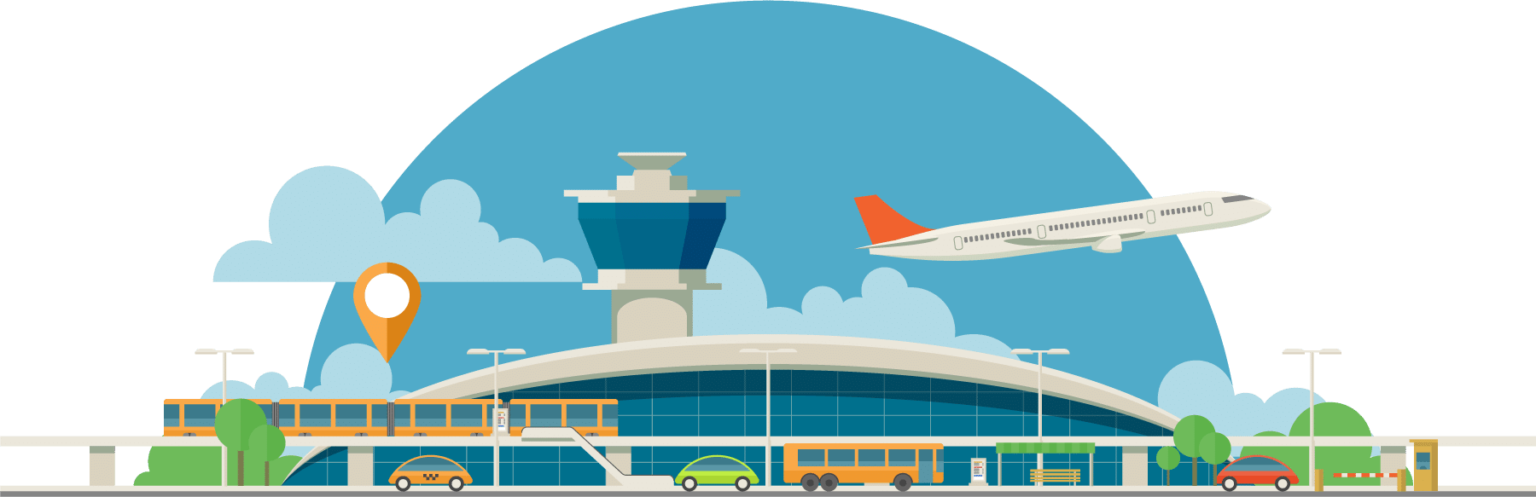

In [ ]:
# установка всех библиотек, необходимых для выполнения ДЗ

!pip install catboost -q
!pip install mlxtend --upgrade -q
!pip install optuna -q
!pip install lime -q
!pip install shap -q
!pip install missingno -q
!pip install psycopg2-binary -q
#!pip install xgboost
#!brew install cmake libomp
#!pip install lightgbm

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **Часть 1: Получение данных, обработка и EDA (2.75 балла)**

В этой части вам необходимо:
- Загрузить данные из БД и предобработать их (1.75 бала)
- Провести разведочный анализ данных (1. балл)

## **1. 1. Загрузка и предобработка данных (1.75 балла)**

In [ ]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2025-02-02 21:26:49--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2025-02-02 21:26:50 (1.02 GB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



### **Задание 1. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

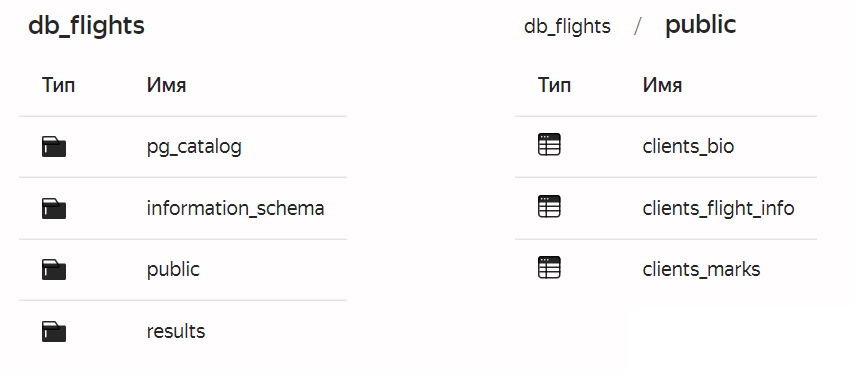



In [ ]:
schema_query = """
SELECT table_name, column_name, data_type
FROM information_schema.columns
WHERE table_schema = 'public' AND table_name IN ('clients_bio', 'clients_flight_info', 'clients_marks')
ORDER BY table_name, ordinal_position;
"""

In [ ]:
try:
    conn = psycopg2.connect(
        dbname='db_flights',
        user='mlhs_student',
        password='mlhs_student',
        host='rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net',
        port=6432,
        sslmode='verify-full',
        target_session_attrs='read-write'
    )
    schema_df = pd.read_sql(schema_query, conn)

finally:
    if 'conn' in locals() and conn:
        conn.close()

<ipython-input-5-c0c385fd6d21>:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  schema_df = pd.read_sql(schema_query, conn)


In [ ]:
schema_df

table_name                        column_name data_type
0           clients_bio                                 id   integer
1           clients_bio                             gender      text
2           clients_bio                                age      text
3   clients_flight_info                                 id   integer
4   clients_flight_info                      Customer Type      text
5   clients_flight_info                     Type of Travel      text
6   clients_flight_info                              class      text
7   clients_flight_info                    Flight Distance      text
8   clients_flight_info         Departure Delay in Minutes      text
9   clients_flight_info           Arrival Delay in Minutes      text
10        clients_marks                                 id   integer
11        clients_marks              Inflight wifi service      text
12        clients_marks  Departure/Arrival time convenient      text
13        clients_marks             Ease of Online booking      text
14        clients_marks                      Gate location      text
15        clients_marks                     Food and drink      text
16        clients_marks                    Online boarding      text
17        clients_marks                       Seat comfort      text
18        clients_marks             Inflight entertainment      text
19        clients_marks                   On-board service      text
20        clients_marks                   Leg room service      text
21        clients_marks                   Baggage handling      text
22        clients_marks                    Checkin service      text
23        clients_marks                   Inflight service      text
24        clients_marks                        cleanliness      text
25        clients_marks                       satisfaction      text

In [ ]:
query = """
SELECT
    c_bio.id,
    c_bio.gender,
    c_bio.age,
    c_info."Customer Type",
    c_info."Type of Travel",
    c_info.class,
    c_info."Flight Distance",
    c_info."Departure Delay in Minutes",
    c_info."Arrival Delay in Minutes",
    c_marks."Inflight wifi service",
    c_marks."Departure/Arrival time convenient",
    c_marks."Ease of Online booking",
    c_marks."Gate location",
    c_marks."Food and drink",
    c_marks."Online boarding",
    c_marks."Seat comfort",
    c_marks."Inflight entertainment",
    c_marks."On-board service",
    c_marks."Leg room service",
    c_marks."Baggage handling",
    c_marks."Checkin service",
    c_marks."Inflight service",
    c_marks.cleanliness,
    c_marks.satisfaction
FROM public.clients_bio AS c_bio
JOIN public.clients_flight_info AS c_info ON c_bio.id = c_info.id
JOIN public.clients_marks AS c_marks ON c_bio.id = c_marks.id;
"""

In [ ]:
try:
    conn = psycopg2.connect(
        dbname='db_flights',
        user='mlhs_student',
        password='mlhs_student',
        host='rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net',
        port=6432,
        sslmode='verify-full',
        target_session_attrs='read-write'
    )
    df = pd.read_sql(query, conn)
finally:
    if 'conn' in locals() and conn:
        conn.close()

<ipython-input-8-6d93b461a362>:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [ ]:
df.shape

(129549, 24)

In [ ]:
df.head(2)

id gender   age      Customer Type   Type of Travel     class  \
0   7   Male  43.0     Loyal Customer  Business travel  Business   
1  13   Male  24.0  disloyal Customer  Business travel       Eco   

  Flight Distance Departure Delay in Minutes Arrival Delay in Minutes  \
0          1963.0                        0.0                      0.0   
1           453.0                       16.0                     30.0   

  Inflight wifi service  ... Online boarding Seat comfort  \
0                   3.0  ...             4.0          5.0   
1                   2.0  ...             2.0          5.0   

  Inflight entertainment On-board service Leg room service Baggage handling  \
0                    5.0              5.0              5.0              5.0   
1                    5.0              2.0              4.0              4.0   

  Checkin service Inflight service cleanliness             satisfaction  
0             4.0              5.0         4.0                satisfied  
1             2.0              4.0         5.0  neutral or dissatisfied  

[2 rows x 24 columns]

In [ ]:
df.set_index("id", inplace=True)

In [ ]:
assert df.shape == (129_549, 23)

### **Задание 2 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129549 entries, 7 to 129876
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   gender                             129549 non-null  object
 1   age                                129549 non-null  object
 2   Customer Type                      129549 non-null  object
 3   Type of Travel                     129549 non-null  object
 4   class                              129549 non-null  object
 5   Flight Distance                    129549 non-null  object
 6   Departure Delay in Minutes         129549 non-null  object
 7   Arrival Delay in Minutes           129549 non-null  object
 8   Inflight wifi service              129549 non-null  object
 9   Departure/Arrival time convenient  129549 non-null  object
 10  Ease of Online booking             129549 non-null  object
 11  Gate location                      129549 non-null  objec

In [ ]:
pd.set_option("display.max_columns", None)

In [ ]:
df.head(2)

gender   age      Customer Type   Type of Travel     class Flight Distance  \
id                                                                              
7    Male  43.0     Loyal Customer  Business travel  Business          1963.0   
13   Male  24.0  disloyal Customer  Business travel       Eco           453.0   

   Departure Delay in Minutes Arrival Delay in Minutes Inflight wifi service  \
id                                                                             
7                         0.0                      0.0                   3.0   
13                       16.0                     30.0                   2.0   

   Departure/Arrival time convenient Ease of Online booking Gate location  \
id                                                                          
7                                3.0                    3.0           3.0   
13                               2.0                    2.0           4.0   

   Food and drink Online boarding Seat comfort Inflight entertainment  \
id                                                                      
7             5.0             4.0          5.0                    5.0   
13            5.0             2.0          5.0                    5.0   

   On-board service Leg room service Baggage handling Checkin service  \
id                                                                      
7               5.0              5.0              5.0             4.0   
13              2.0              4.0              4.0             2.0   

   Inflight service cleanliness             satisfaction  
id                                                        
7               5.0         4.0                satisfied  
13              4.0         5.0  neutral or dissatisfied

In [ ]:
for col in df.columns:
    try:
        df[col] = df[col].astype(float)
    except ValueError:
        pass

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129549 entries, 7 to 129876
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   gender                             129549 non-null  object 
 1   age                                129234 non-null  float64
 2   Customer Type                      129549 non-null  object 
 3   Type of Travel                     129549 non-null  object 
 4   class                              129549 non-null  object 
 5   Flight Distance                    129455 non-null  float64
 6   Departure Delay in Minutes         129442 non-null  float64
 7   Arrival Delay in Minutes           129042 non-null  float64
 8   Inflight wifi service              129505 non-null  float64
 9   Departure/Arrival time convenient  129500 non-null  float64
 10  Ease of Online booking             129506 non-null  float64
 11  Gate location                      129512 no

Так. Привели к числовому типу правильно. Теперь посмотрим на пропуски и выбросы.

In [ ]:
df.isnull().sum()

gender                                 0
age                                  315
Customer Type                          0
Type of Travel                         0
class                                  0
Flight Distance                       94
Departure Delay in Minutes           107
Arrival Delay in Minutes             507
Inflight wifi service                 44
Departure/Arrival time convenient     49
Ease of Online booking                43
Gate location                         37
Food and drink                        50
Online boarding                       46
Seat comfort                          47
Inflight entertainment                45
On-board service                      44
Leg room service                      46
Baggage handling                      48
Checkin service                       42
Inflight service                      63
cleanliness                           37
satisfaction                           0
dtype: int64

In [ ]:
df_numeric = df.select_dtypes(include=["float64"])
q1 = df_numeric.quantile(0.25)
q3 = df_numeric.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

vybrosy = ((df_numeric < lower_bound) | (df_numeric > upper_bound)).sum()

In [ ]:
vybrosy

age                                    448
Flight Distance                       3074
Departure Delay in Minutes           18124
Arrival Delay in Minutes             17499
Inflight wifi service                   24
Departure/Arrival time convenient       35
Ease of Online booking                  29
Gate location                           39
Food and drink                          28
Online boarding                         32
Seat comfort                            34
Inflight entertainment                  23
On-board service                        26
Leg room service                        39
Baggage handling                        27
Checkin service                      16103
Inflight service                        39
cleanliness                             25
dtype: int64

Ого сколько выбросов во времени прибытия и отправления.

In [ ]:
del df_numeric, vybrosy
import gc
gc.collect()

0

### **Задание 3 (0.5 балла)**

Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме. Постройте:
-  `matrix` пропущенных значений;
- столбчатую диаграмму в **логарифмированной** шкале (так как пропусков немного, по обычной не будет видно, в каких столбцах их больше)

<Figure size 1000x600 with 0 Axes>

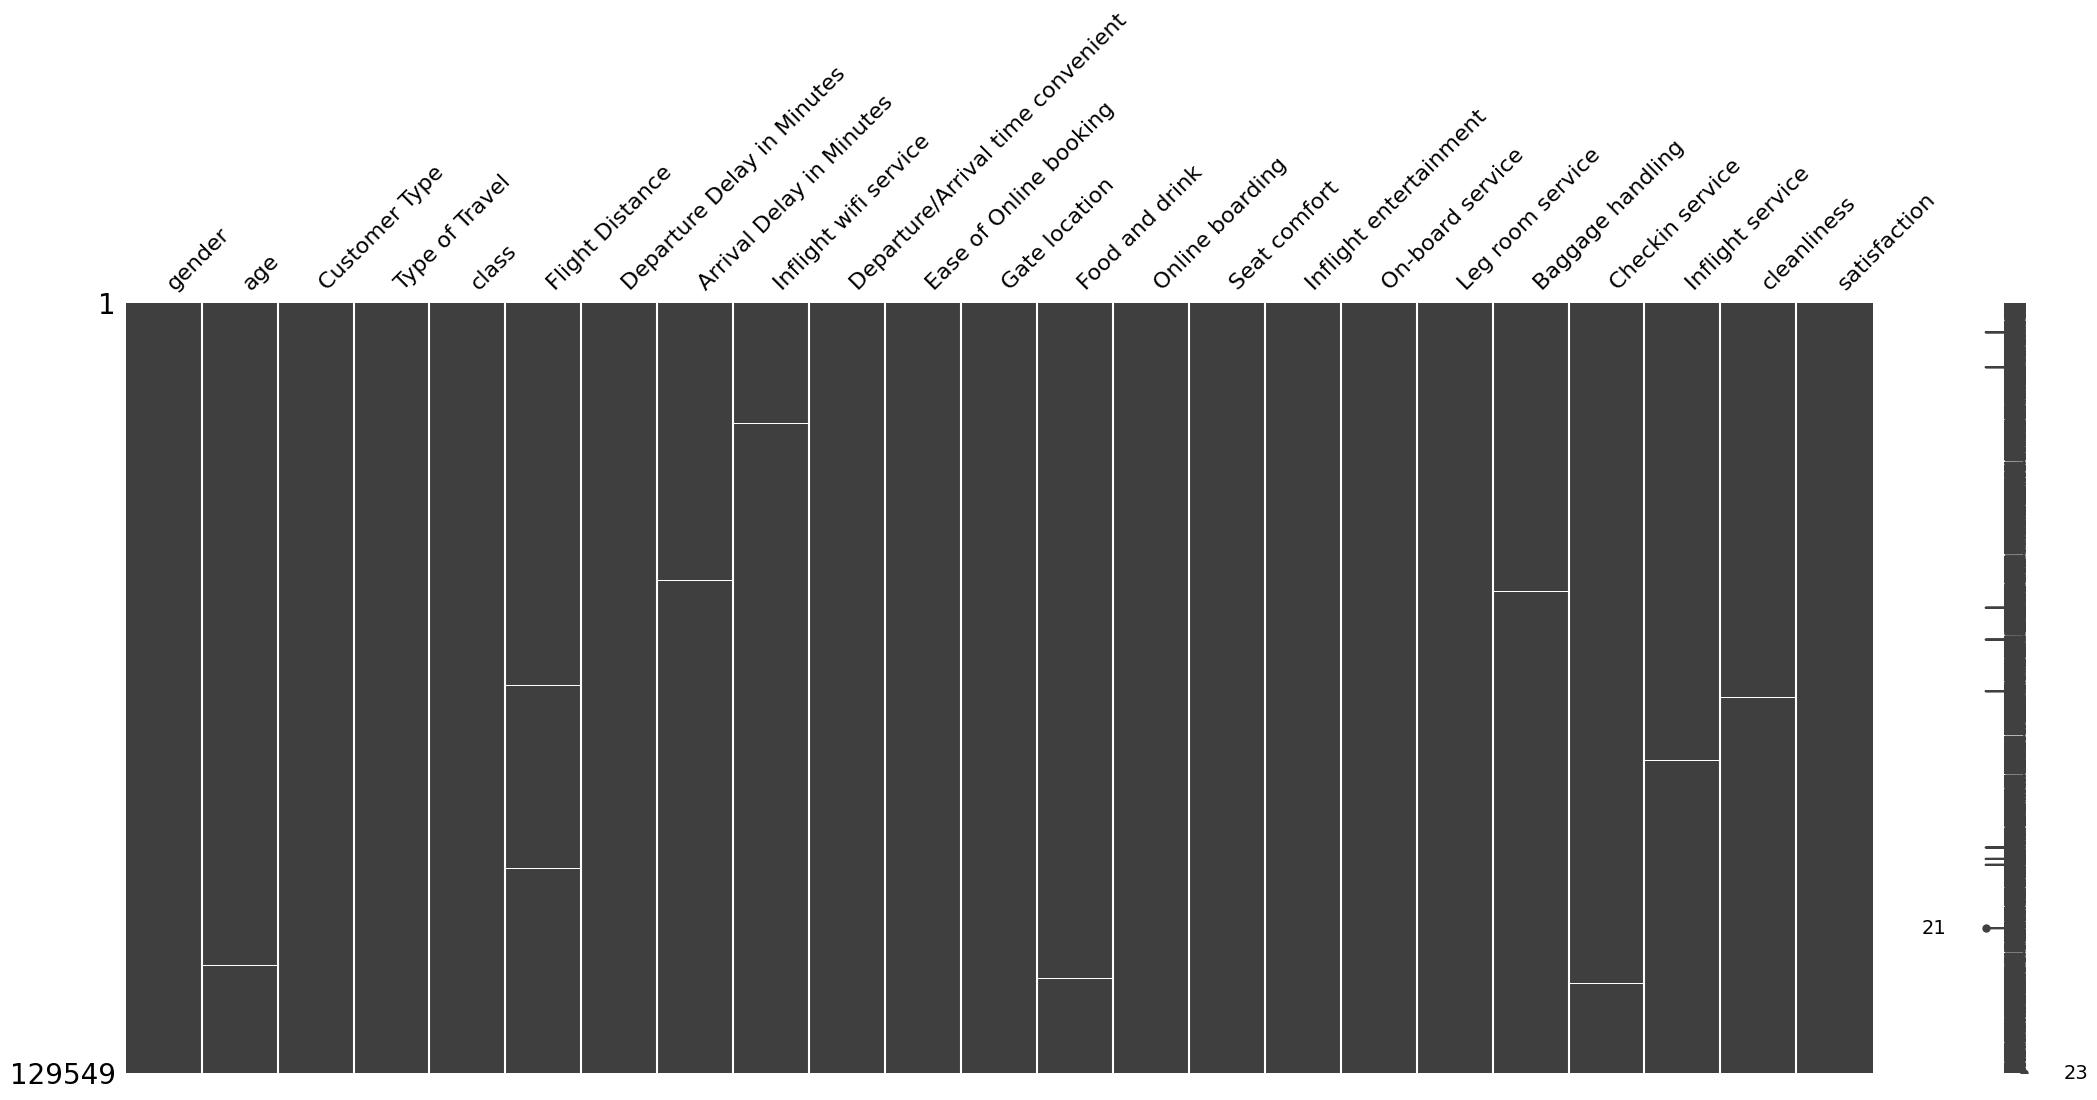

In [ ]:
plt.figure(figsize=(10, 6))
missingno.matrix(df)
plt.show()

/usr/local/lib/python3.11/dist-packages/missingno/missingno.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(n * len(df)) for n in ax1.get_yticks()], fontsize=fontsize)


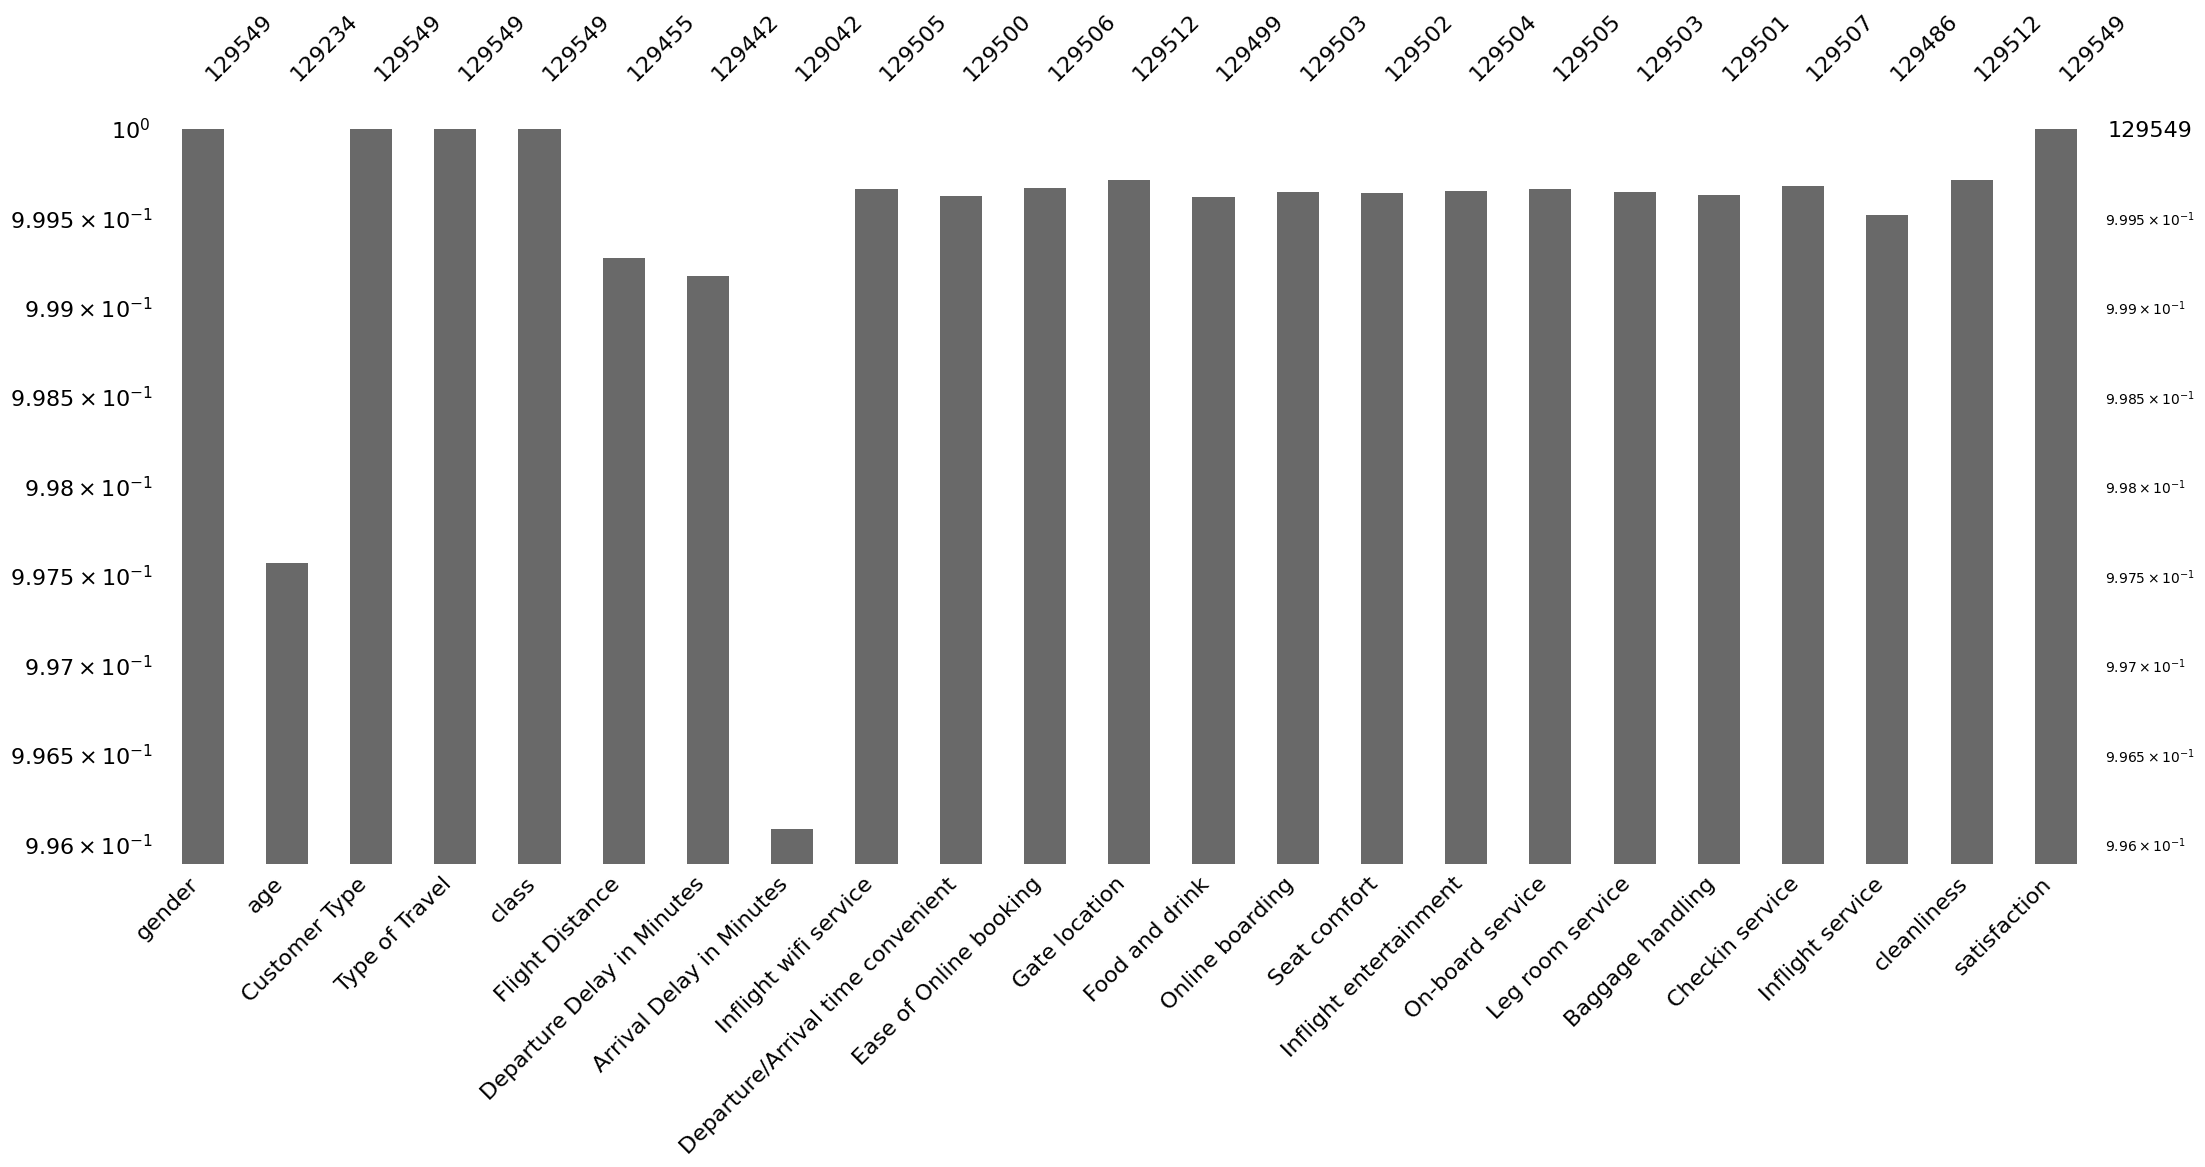

In [ ]:
plt.figure(figsize=(10, 6))
missingno.bar(df, log=True)
plt.show()

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [ ]:
df.satisfaction.value_counts()

satisfaction
neutral or dissatisfied    58732
satisfied                  44912
-                          25905
Name: count, dtype: int64

In [ ]:
df_train = df[df.satisfaction != '-']
df_train

gender   age      Customer Type   Type of Travel     class  \
id                                                                   
7         Male  43.0     Loyal Customer  Business travel  Business   
13        Male  24.0  disloyal Customer  Business travel       Eco   
18      Female  61.0     Loyal Customer  Personal Travel       Eco   
31        Male  35.0  disloyal Customer  Business travel  Business   
39      Female  46.0     Loyal Customer  Business travel  Business   
...        ...   ...                ...              ...       ...   
129831  Female  28.0     Loyal Customer  Personal Travel       Eco   
129837    Male  66.0     Loyal Customer  Personal Travel       Eco   
129838  Female  59.0     Loyal Customer  Personal Travel       Eco   
129839    Male  61.0     Loyal Customer  Personal Travel       Eco   
129846    Male  44.0     Loyal Customer  Personal Travel       Eco   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
7                1963.0                         0.0                       0.0   
13                453.0                        16.0                      30.0   
18                821.0                         0.0                       0.0   
31                212.0                         0.0                       0.0   
39                 67.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129831            447.0                        23.0                      16.0   
129837            337.0                       199.0                     213.0   
129838            308.0                        32.0                      24.0   
129839            337.0                         0.0                       0.0   
129846            447.0                         0.0                       0.0   

        Inflight wifi service  Departure/Arrival time convenient  \
id                                                                 
7                         3.0                                3.0   
13                        2.0                                2.0   
18                        2.0                                5.0   
31                        2.0                                2.0   
39                        3.0                                3.0   
...                       ...                                ...   
129831                    1.0                                3.0   
129837                    2.0                                4.0   
129838                    3.0                                5.0   
129839                    2.0                                4.0   
129846                    2.0                                5.0   

        Ease of Online booking  Gate location  Food and drink  \
id                                                              
7                          3.0            3.0             5.0   
13                         2.0            4.0             5.0   
18                         2.0            1.0             4.0   
31                         2.0            1.0             2.0   
39                         3.0            3.0             4.0   
...                        ...            ...             ...   
129831                     1.0            5.0             3.0   
129837                     2.0            3.0             2.0   
129838                     3.0            4.0             2.0   
129839                     2.0            3.0             3.0   
129846                     2.0            3.0             5.0   

        Online boarding  Seat comfort  Inflight entertainment  \
id                                                              
7                   4.0           5.0                     5.0   
13                  2.0           5.0                     5.0   
18                  1.0           5.0               

In [ ]:
assert df_train.shape == (103_644, 23)

In [ ]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test

gender   age   Customer Type   Type of Travel     class  \
id                                                                
55        Male  36.0  Loyal Customer  Business travel  Business   
79      Female  70.0  Loyal Customer  Personal Travel       Eco   
126       Male  66.0  Loyal Customer  Personal Travel       Eco   
199     Female  60.0  Loyal Customer  Business travel  Business   
263       Male  43.0  Loyal Customer  Personal Travel  Business   
...        ...   ...             ...              ...       ...   
129750    Male  38.0  Loyal Customer  Business travel       Eco   
129771    Male  16.0  Loyal Customer  Personal Travel       Eco   
129798  Female  43.0  Loyal Customer  Personal Travel       Eco   
129868    Male  47.0  Loyal Customer  Business travel  Eco Plus   
129876    Male  28.0  Loyal Customer  Personal Travel  Eco Plus   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
55               3655.0                        40.0                      71.0   
79                108.0                        50.0                      41.0   
126               562.0                        88.0                      84.0   
199              3756.0                        36.0                      24.0   
263               802.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129750            337.0                        92.0                      82.0   
129771            308.0                         2.0                       0.0   
129798            308.0                         0.0                       0.0   
129868            447.0                         0.0                       0.0   
129876            447.0                         2.0                       3.0   

        Inflight wifi service  Departure/Arrival time convenient  \
id                                                                 
55                        1.0                                1.0   
79                        5.0                                4.0   
126                       2.0                                5.0   
199                       4.0                                4.0   
263                       1.0                                2.0   
...                       ...                                ...   
129750                    4.0                                3.0   
129771                    3.0                                4.0   
129798                    2.0                                4.0   
129868                    3.0                                4.0   
129876                    4.0                                4.0   

        Ease of Online booking  Gate location  Food and drink  \
id                                                              
55                         1.0            1.0             1.0   
79                         0.0            3.0             4.0   
126                        2.0            4.0             5.0   
199                        4.0            4.0             2.0   
263                        1.0            3.0             2.0   
...                        ...            ...             ...   
129750                     3.0            3.0             4.0   
129771                     3.0            3.0             1.0   
129798                     2.0            2.0             3.0   
129868                     4.0            4.0             4.0   
129876                     4.0            2.0             4.0   

        Online boarding  Seat comfort  Inflight entertainment  \
id                                                              
55                  3.0           3.0                     3.0   
79                  4.0           4.0                     3.0   
126                 2.0           5.0                     5.0   
199                 4.0   

In [ ]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [ ]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 4. (0.15 балла)**

Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.

**Примечание:** Мы также могли восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Как правило, такое заполнение точнее и лучше сохраняет структуру распределений. Но для признаков в нашей задаче Imputer'ы, реализованные библиотечно не подошли бы. Они возвращали бы вещественные значения, а в нашей задаче все признаки целые.

In [ ]:
most_frequent = X_train.mode().iloc[0]
most_frequent

gender                                        Female
age                                             39.0
Customer Type                         Loyal Customer
Type of Travel                       Business travel
class                                       Business
Flight Distance                                337.0
Departure Delay in Minutes                       0.0
Arrival Delay in Minutes                         0.0
Inflight wifi service                            3.0
Departure/Arrival time convenient                4.0
Ease of Online booking                           3.0
Gate location                                    3.0
Food and drink                                   4.0
Online boarding                                  4.0
Seat comfort                                     4.0
Inflight entertainment                           4.0
On-board service                                 4.0
Leg room service                                 4.0
Baggage handling                                 4.0
Checkin service                                  4.0
Inflight service                                 4.0
cleanliness                                      4.0
Name: 0, dtype: object

In [ ]:
X_train.fillna(most_frequent, inplace=True)
X_val.fillna(most_frequent, inplace=True)
df_test.fillna(most_frequent, inplace=True)

In [ ]:
y_train.isna().sum()

0

In [ ]:
X_train.isna().sum()

gender                               0
age                                  0
Customer Type                        0
Type of Travel                       0
class                                0
Flight Distance                      0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
cleanliness                          0
dtype: int64

In [ ]:
object_columns = X_train.select_dtypes(include=['object']).columns

In [ ]:
object_columns

Index(['gender', 'Customer Type', 'Type of Travel', 'class'], dtype='object')

In [ ]:
for col in object_columns:
  print(X_train[col].value_counts())

gender
Female    36816
Male      35734
Name: count, dtype: int64
Customer Type
Loyal Customer       59354
disloyal Customer    13144
nan                     52
Name: count, dtype: int64
Type of Travel
Business travel    49984
Personal Travel    22496
nan                   70
Name: count, dtype: int64
class
Business    34727
Eco         32546
Eco Plus     5211
nan            66
Name: count, dtype: int64


Видим, что остались еще nan. Заменим их на моду

In [ ]:
for data in [X_train, X_val, df_test]:
    data.replace("nan", np.nan, inplace=True)
    data.fillna(most_frequent, inplace=True)

In [ ]:
for col in object_columns:
  print(X_train[col].value_counts())

gender
Female    36816
Male      35734
Name: count, dtype: int64
Customer Type
Loyal Customer       59406
disloyal Customer    13144
Name: count, dtype: int64
Type of Travel
Business travel    50054
Personal Travel    22496
Name: count, dtype: int64
class
Business    34793
Eco         32546
Eco Plus     5211
Name: count, dtype: int64


Теперь все хорошо!

### **Задание 5. (0.1 балла)**

- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

In [ ]:
X_train.describe()

age  Flight Distance  Departure Delay in Minutes  \
count  72550.000000     72550.000000                72550.000000   
mean      40.098856      1329.018332                   15.859366   
std       20.658196      4764.369357                   70.861937   
min        0.000000         0.000000                    0.000000   
25%       27.000000       413.000000                    0.000000   
50%       40.000000       844.000000                    0.000000   
75%       51.000000      1744.000000                   12.000000   
max      544.000000    379620.000000                 9282.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count              72550.000000           72550.000000   
mean                  16.645968               2.733687   
std                   97.990293               1.362172   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
max                11760.000000              45.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                       72550.000000            72550.000000   
mean                            3.065017                2.761006   
std                             1.552254                1.414843   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                            45.000000               28.000000   

       Gate location  Food and drink  Online boarding  Seat comfort  \
count   72550.000000    72550.000000     72550.000000  72550.000000   
mean        2.982688        3.209318         3.256513      3.445665   
std         1.316648        1.349963         1.372739      1.346077   
min         0.000000        0.000000         0.000000      0.000000   
25%         2.000000        2.000000         2.000000      2.000000   
50%         3.000000        3.000000         3.000000      4.000000   
75%         4.000000        4.000000         4.000000      5.000000   
max        36.000000       36.000000        32.000000     45.000000   

       Inflight entertainment  On-board service  Leg room service  \
count            72550.000000      72550.000000      72550.000000   
mean                 3.362150          3.383101          3.352364   
std                  1.360862          1.333758          1.360180   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                 40.000000         45.000000         36.000000   

       Baggage handling  Checkin service  Inflight service   cleanliness  
count      72550.000000     72550.000000      72550.000000  72550.000000  
mean           3.630255         3.309056          3.640234      3.291178  
std            1.227853         1.293114          1.215114      1.343302  
min            0.000000         0.000000          0.000000      0.000000  
25%            3.000000         3.000000          3.000000      2.000000  
50%            4.000000         3.000000          4.000000      3.000000  
75%            5.000000         4.000000          5.000000      4.000000  
max           40.000000        45.000000         36.000000     45.000000

In [ ]:
X_train.describe(include=["object"])

gender   Customer Type   Type of Travel     class
count    72550           72550            72550     72550
unique       2               2                2         3
top     Female  Loyal Customer  Business travel  Business
freq     36816           59406            50054     34793

In [ ]:
X_val.describe()

age  Flight Distance  Departure Delay in Minutes  \
count  31094.000000     31094.000000                31094.000000   
mean      39.955779      1316.469480                   15.666945   
std       19.549492      4379.003672                   80.658377   
min        0.000000         0.000000                    0.000000   
25%       27.000000       417.000000                    0.000000   
50%       40.000000       845.000000                    0.000000   
75%       51.000000      1744.000000                   12.000000   
max      612.000000    255522.000000                11011.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count              31094.000000           31094.000000   
mean                  16.871776               2.732521   
std                  131.103562               1.348038   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
max                14006.000000              40.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                       31094.000000            31094.000000   
mean                            3.064836                2.758989   
std                             1.558570                1.439010   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                            35.000000               45.000000   

       Gate location  Food and drink  Online boarding  Seat comfort  \
count   31094.000000    31094.000000     31094.000000  31094.000000   
mean        2.978195        3.195215         3.252589      3.438477   
std         1.290490        1.358929         1.414625      1.356474   
min         1.000000        0.000000         0.000000      0.000000   
25%         2.000000        2.000000         2.000000      2.000000   
50%         3.000000        3.000000         3.000000      4.000000   
75%         4.000000        4.000000         4.000000      5.000000   
max        32.000000       45.000000        40.000000     36.000000   

       Inflight entertainment  On-board service  Leg room service  \
count            31094.000000      31094.000000      31094.000000   
mean                 3.359265          3.394578          3.367756   
std                  1.358533          1.337013          1.379536   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                 36.000000         40.000000         40.000000   

       Baggage handling  Checkin service  Inflight service   cleanliness  
count      31094.000000     31094.000000      31094.000000  31094.000000  
mean           3.648775         3.306908          3.655303      3.286776  
std            1.224217         1.321872          1.204409      1.345356  
min            1.000000         0.000000          1.000000      0.000000  
25%            3.000000         3.000000          3.000000      2.000000  
50%            4.000000         3.000000          4.000000      3.000000  
75%            5.000000         4.000000          5.000000      4.000000  
max           40.000000        45.000000         35.000000     40.000000

In [ ]:
X_val.describe(include=["object"])

gender   Customer Type   Type of Travel     class
count    31094           31094            31094     31094
unique       2               2                2         3
top     Female  Loyal Customer  Business travel  Business
freq     15774           25315            21457     14783

Выводы:
* Возраст в среднем 40 лет, но есть маленькие дети и пожилые люди.
* Дистанция полета разная, есть очень длинные рейсы.
* Задержки бывают большими, есть выбросы.
* Оценки сервисов идут от 1 до 5, часто повторяются.
* Женщин чуть больше, лояльных клиентов намного больше.
* Чаще летают в командировки, чем для отдыха.
* Больше всего пассажиров в бизнес-классе.
* В целом данные не очень равномерные, есть выбросы и дисбаланс.

### **Задание 6 (0.25 балла)**

- Удалите строки c выбросами в числовых столбцах (для трейна и валидации; тест оставьте без изменений).

**Примечание:** Выбросами считайте значения признака, строго превышающие 0.996-квантиль.

По определению, квантиль — значение, которое заданная случайная величина не превышает с фиксированной вероятностью. То есть, если мы смотрим на квантиль 0.996-квантиль, то значения после этого квантиля встречаются в 0.004% случаев. В среднем для всех признаков эти значения начинаются ~в этом квантиле.



In [ ]:
quantile_996 = X_train.quantile(0.996, numeric_only=True)
quantile_996

age                                    80.0
Flight Distance                      3980.0
Departure Delay in Minutes            265.0
Arrival Delay in Minutes              270.0
Inflight wifi service                   5.0
Departure/Arrival time convenient       5.0
Ease of Online booking                  5.0
Gate location                           5.0
Food and drink                          5.0
Online boarding                         5.0
Seat comfort                            5.0
Inflight entertainment                  5.0
On-board service                        5.0
Leg room service                        5.0
Baggage handling                        5.0
Checkin service                         5.0
Inflight service                        5.0
cleanliness                             5.0
Name: 0.996, dtype: float64

In [ ]:
X_train_num = X_train.select_dtypes(include=["float64"])
X_val_num = X_val.select_dtypes(include=["float64"])

In [ ]:
X_train_num.columns

Index(['age', 'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'cleanliness'],
      dtype='object')

In [ ]:
quantile_996 = quantile_996[X_train_num.columns]

In [ ]:
X_train = X_train.loc[(X_train_num <= quantile_996).all(axis=1)]
y_train = y_train.loc[X_train.index]
X_val = X_val.loc[(X_val_num <= quantile_996).all(axis=1)]
y_val = y_val.loc[X_val.index]
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((71395, 22), (71395,), (30600, 22), (30600,))

In [ ]:
assert df_test.shape == (25_905, 22)

In [ ]:
del X_train_num, X_val_num
gc.collect()

22412

## **1. 2. EDA (1 балл)**

Создадим переменные с перечислениями столбцов разного типа

In [ ]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols))
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129549 entries, 7 to 129876
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   gender                             129549 non-null  object 
 1   age                                129234 non-null  float64
 2   Customer Type                      129549 non-null  object 
 3   Type of Travel                     129549 non-null  object 
 4   class                              129549 non-null  object 
 5   Flight Distance                    129455 non-null  float64
 6   Departure Delay in Minutes         129442 non-null  float64
 7   Arrival Delay in Minutes           129042 non-null  float64
 8   Inflight wifi service              129505 non-null  float64
 9   Departure/Arrival time convenient  129500 non-null  float64
 10  Ease of Online booking             129506 non-null  float64
 11  Gate location                      129512 no

In [ ]:
continuous_cols

['age',
 'Flight Distance',
 'Departure Delay in Minutes',
 'Arrival Delay in Minutes']

In [ ]:
ordinal_cols

['Inflight entertainment',
 'Inflight wifi service',
 'Gate location',
 'Leg room service',
 'Seat comfort',
 'Departure/Arrival time convenient',
 'Baggage handling',
 'Food and drink',
 'On-board service',
 'Inflight service',
 'Ease of Online booking',
 'Checkin service',
 'Online boarding',
 'cleanliness']

In [ ]:
categorical_cols

['gender', 'Customer Type', 'Type of Travel', 'class']

In [ ]:
len(continuous_cols + ordinal_cols + categorical_cols)

22

In [ ]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

In [ ]:
del df
gc.collect()

0

### **Задание 7. (0.3 балла)**

- Напишите процедуры для отрисовки графиков;
 * Для признаков, которые мы выделили как порядковые и для категориальных, отображайте только `countplot`
  * Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)

- Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне. Всё должно красиво работать! :)

**Примечание 1:**

Помните про хороший тон визуализации — все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима! За неё также могут быть сняты баллы.

**Примечание 2:**

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

In [ ]:
def plot_ordinal(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    df_with_target = df.copy()
    df_with_target["satisfaction"] = y

    for col in cols:
        plt.figure(figsize=(6, 4))
        sns.countplot(data=df_with_target, x=col, hue="satisfaction")
        plt.title(f"Распределение {col} по удовлетворенности клиентов")
        plt.xlabel(col)
        plt.ylabel("Количество")
        plt.legend(title="Satisfaction")
        plt.xticks(rotation=45)
        plt.show()

In [ ]:
def plot_continuous(cols, df, y):
    """Draws kdeplots and boxplots in one row
    for all columns in 'cols' with informative title
    """
    df_with_target = df.copy()
    df_with_target["satisfaction"] = y

    for col in cols:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        sns.histplot(data=df_with_target, x=col, hue="satisfaction", ax=axes[0])
        axes[0].set_title(f"Распределение {col}")
        axes[0].set_xlabel(col)
        axes[0].set_ylabel("Частота")

        sns.boxplot(data=df_with_target, x="satisfaction", y=col, hue="satisfaction", ax=axes[1])
        axes[1].set_title(f"Ящик с усами для {col}")
        axes[1].set_xlabel("Satisfaction")
        axes[1].set_ylabel(col)

        plt.tight_layout()
        plt.show()

In [ ]:
def plot_categorical(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    df_with_target = df.copy()
    df_with_target["satisfaction"] = y

    for col in cols:
        plt.figure(figsize=(6, 4))
        sns.countplot(data=df_with_target, x=col, hue="satisfaction")
        plt.title(f"Распределение {col} по удовлетворенности клиентов")
        plt.xlabel(col)
        plt.ylabel("Количество")
        plt.legend(title="Satisfaction")
        plt.xticks(rotation=45)
        plt.show()

Отрисовка.

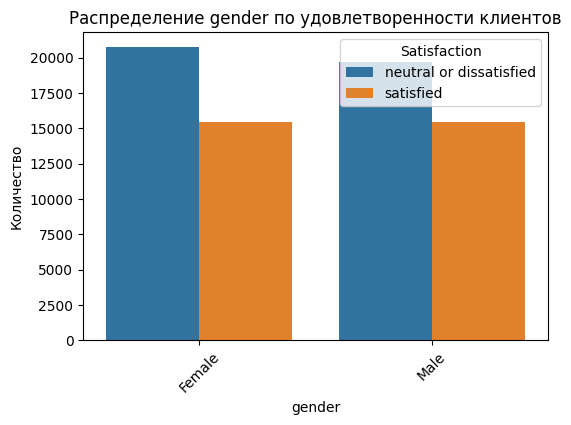

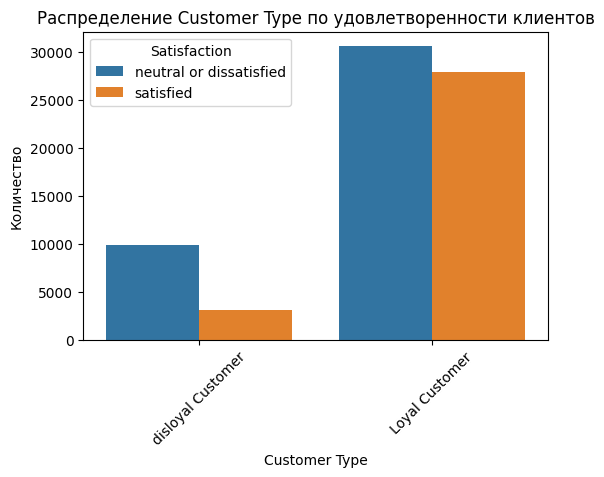

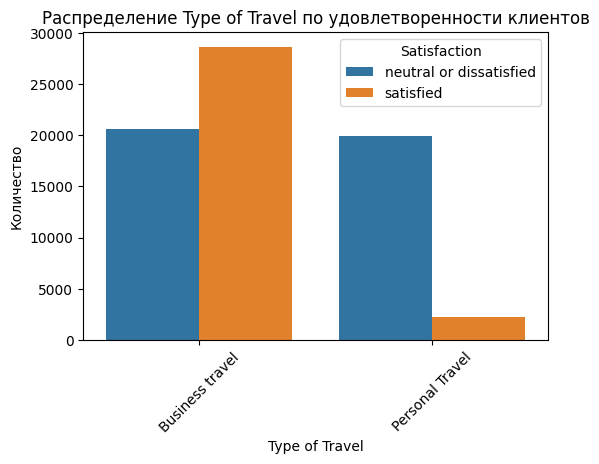

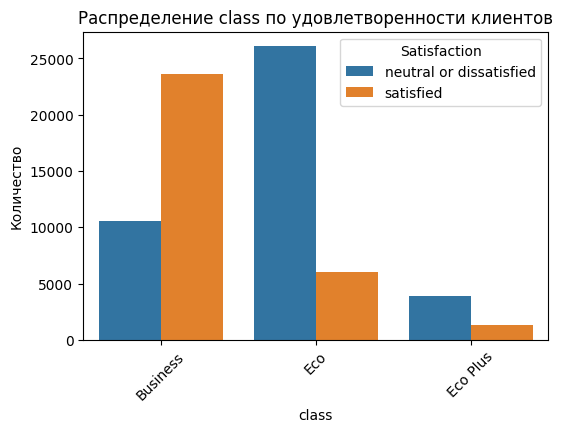

In [ ]:
plot_categorical(categorical_cols, X_train, y_train)

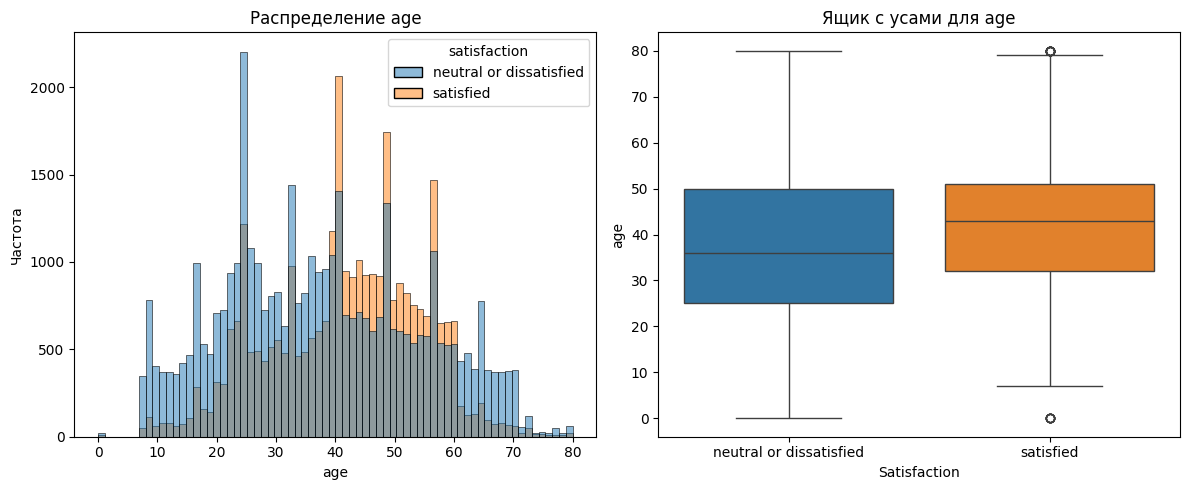

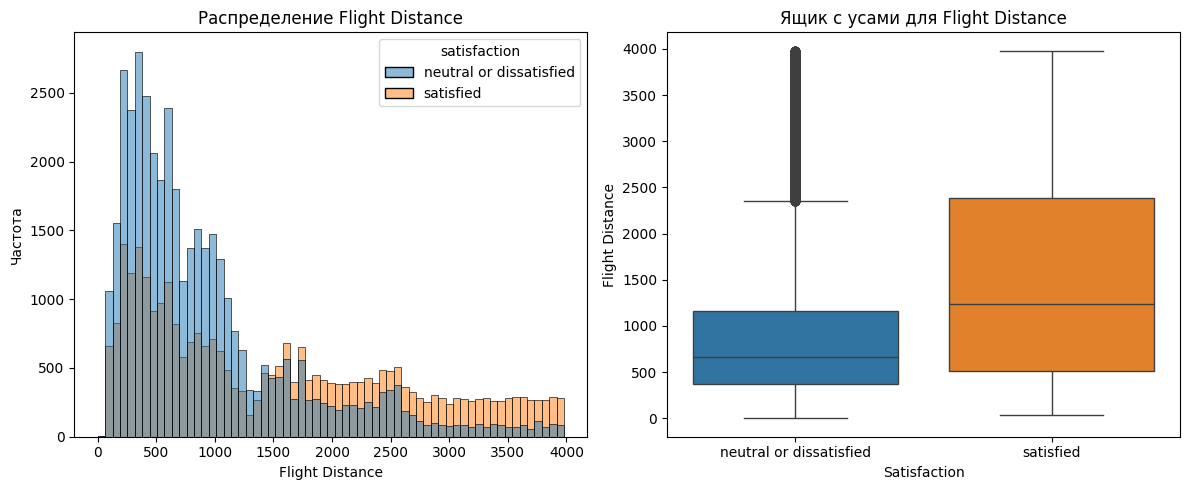

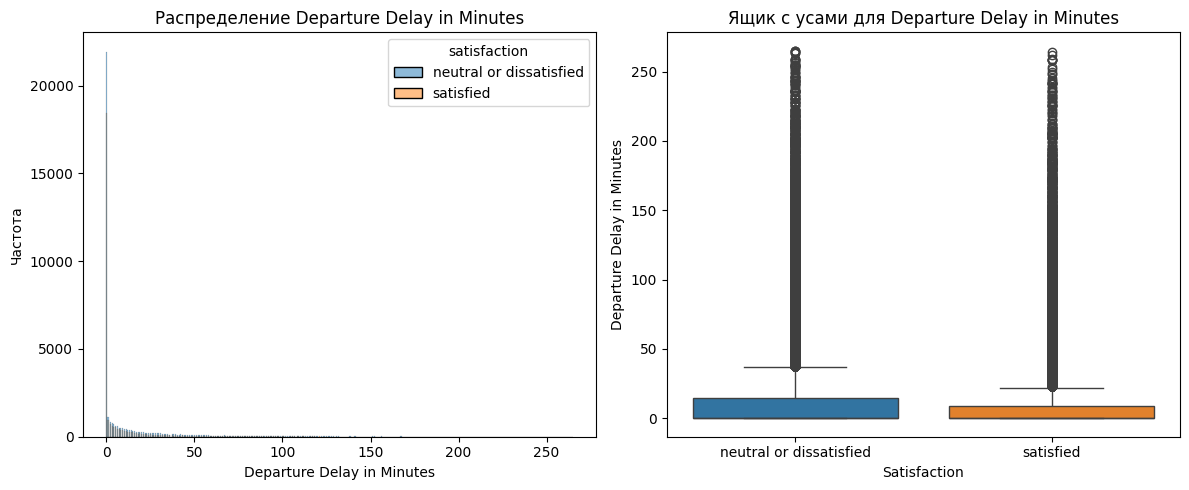

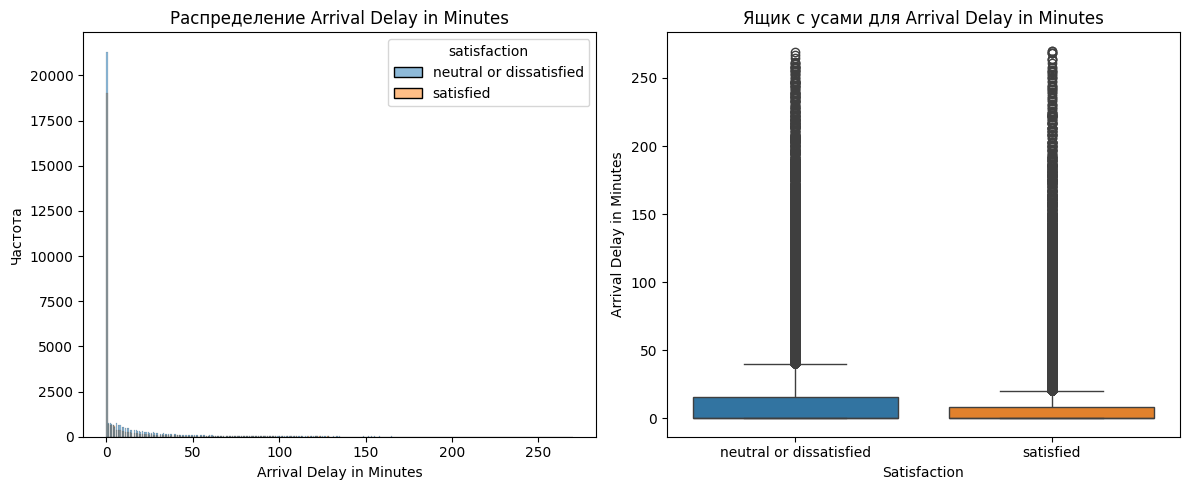

In [ ]:
plot_continuous(continuous_cols, X_train, y_train)

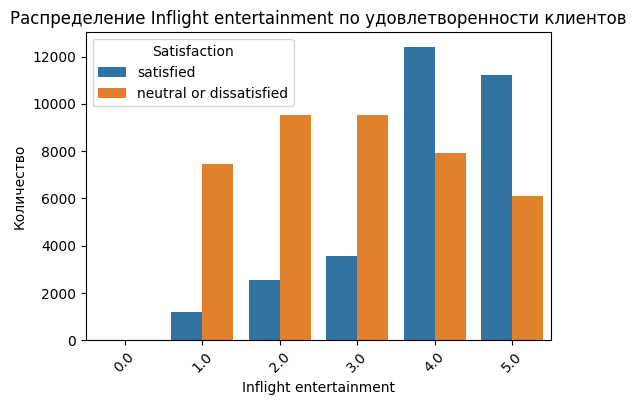

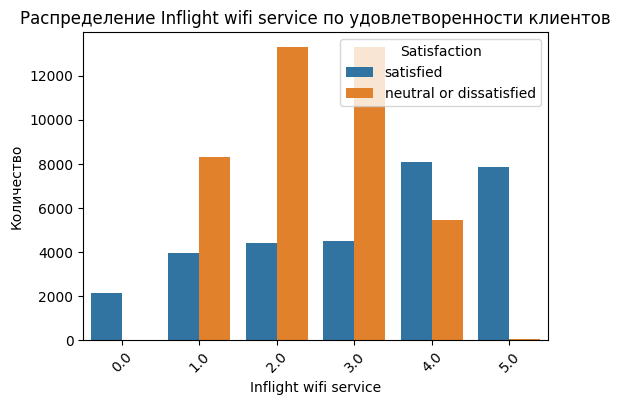

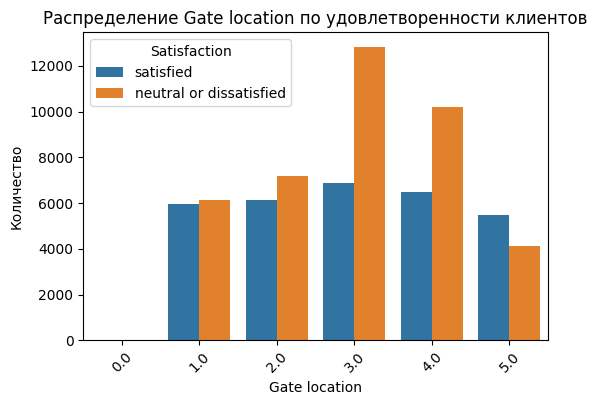

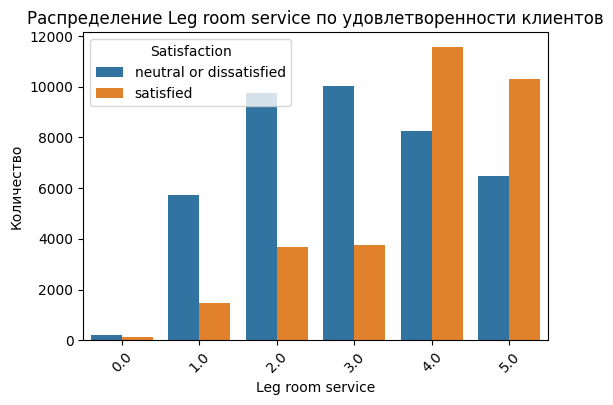

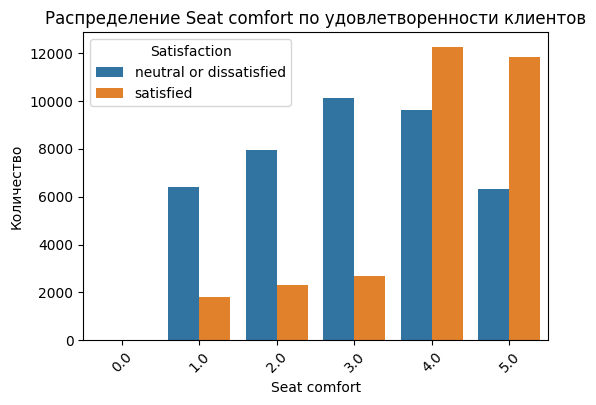

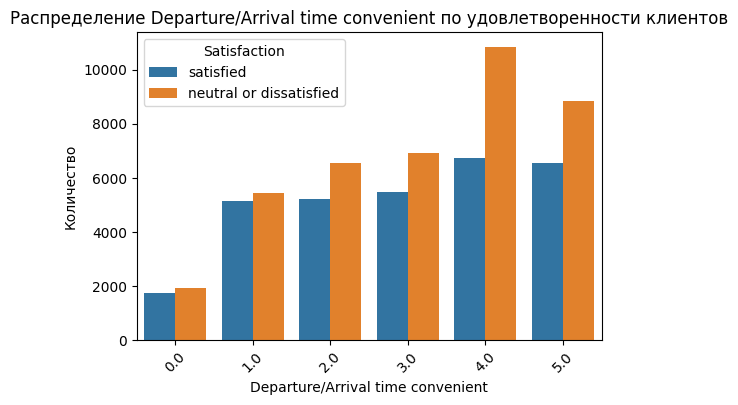

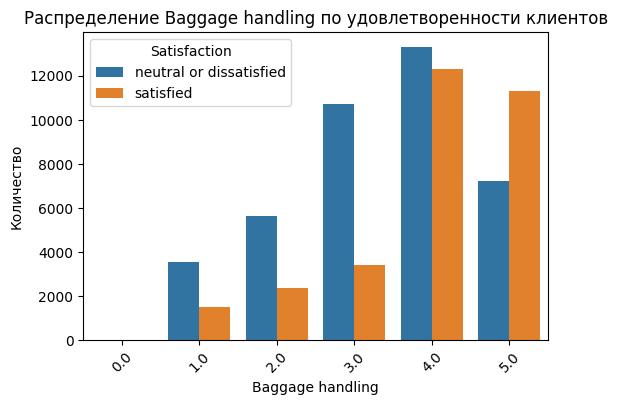

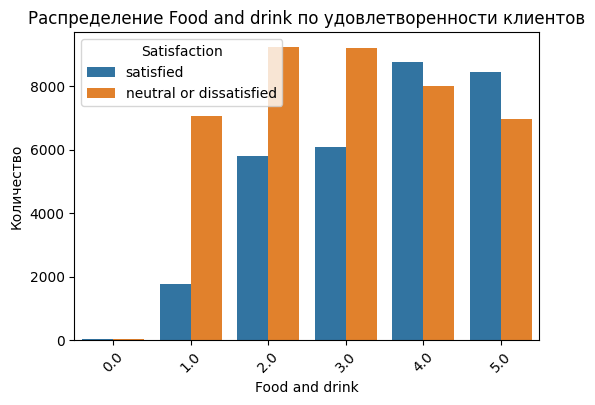

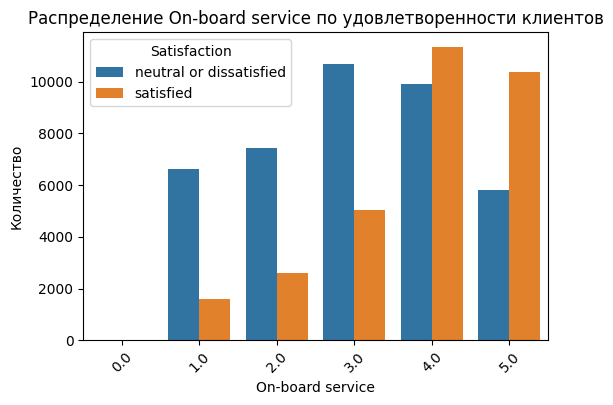

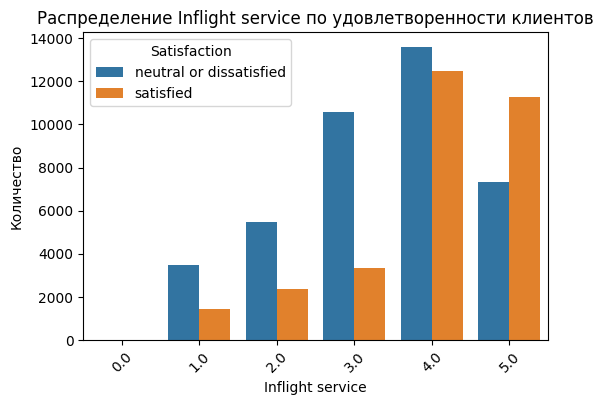

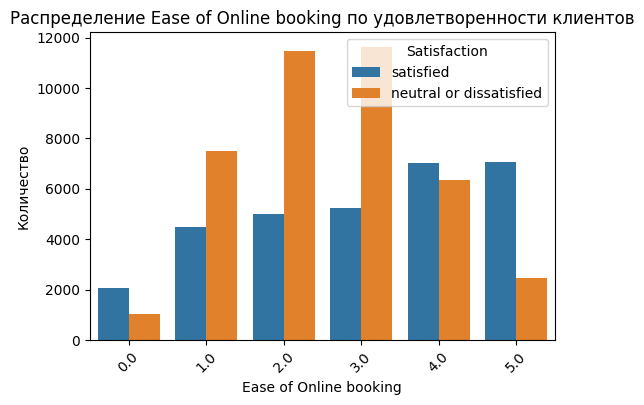

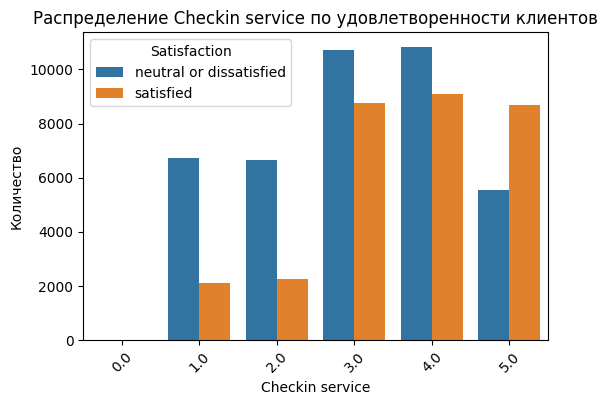

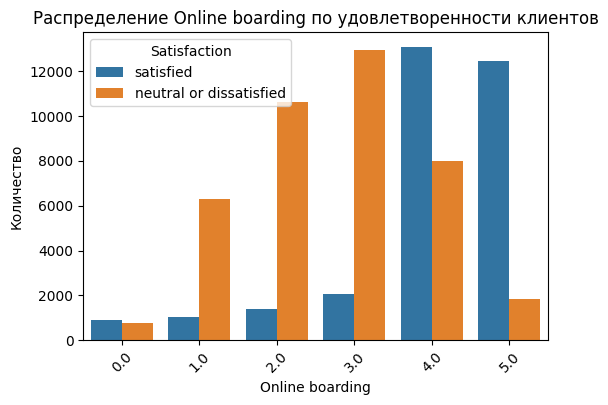

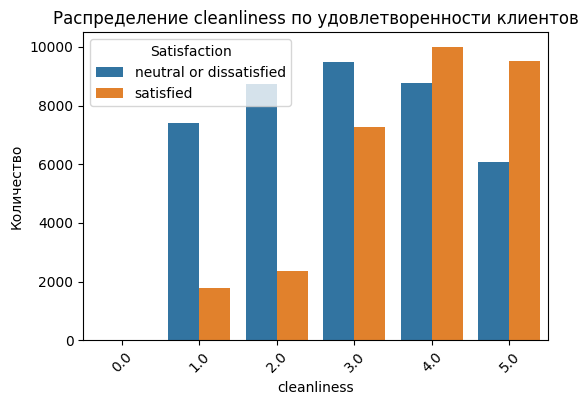

In [ ]:
plot_ordinal(ordinal_cols, X_train, y_train)

Распределение таргета

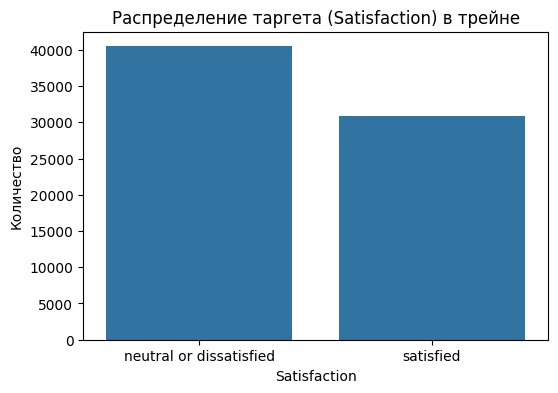

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)
plt.title("Распределение таргета (Satisfaction) в трейне")
plt.xlabel("Satisfaction")
plt.ylabel("Количество")
plt.show()

### **Задание 8 (0.2 балла)**

Сделайте выводы по построенным графикам.

Не забудьте упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки

Выводы по графикам:

* Классы не сбалансированы: довольных больше, чем недовольных.
*	Некоторые признаки распределены неравномерно:
1. Лояльных клиентов больше, чем нелояльных.
2. Чаще летают по бизнесу, а не в личных целях.
3. Бизнес-класс самый популярный, Eco Plus — самый редкий.
4. Много оценок “5” и “1”, сервис чаще оценивают очень хорошо или очень плохо.
* Континуальные признаки:
1. Возраст — похоже на нормальное распределение.
2. Дистанция полета — чаще короткие рейсы, но есть очень длинные.
3. Задержки — большинство небольшие, но есть огромные выбросы.

### **Бонус (0.1 балла)**
По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест.

In [ ]:
def compare_train_test(cols, df_train, df_val, df_test, limits):
    for col, limit in zip(cols, limits):
        plt.figure(figsize=(10, 5))
        sns.histplot(df_train[col], label="Train", kde=True, element="step", fill=False)
        sns.histplot(df_val[col], label="Validation", kde=True, element="step", fill=False)
        sns.histplot(df_test[col], label="Test", kde=True, element="step", fill=False)

        plt.xlim(0, limit)
        plt.title(f"Распределение {col} в Train, Validation и Test")
        plt.xlabel(col)
        plt.ylabel("Частота")
        plt.legend()
        plt.show()

In [ ]:
x_limits = [200, 15000, 100]

In [ ]:
selected_features = ["age", "Flight Distance", "Departure Delay in Minutes"]

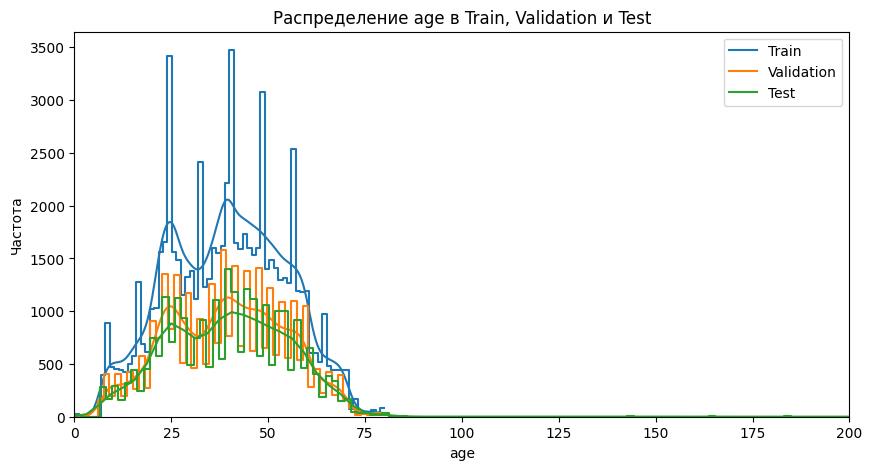

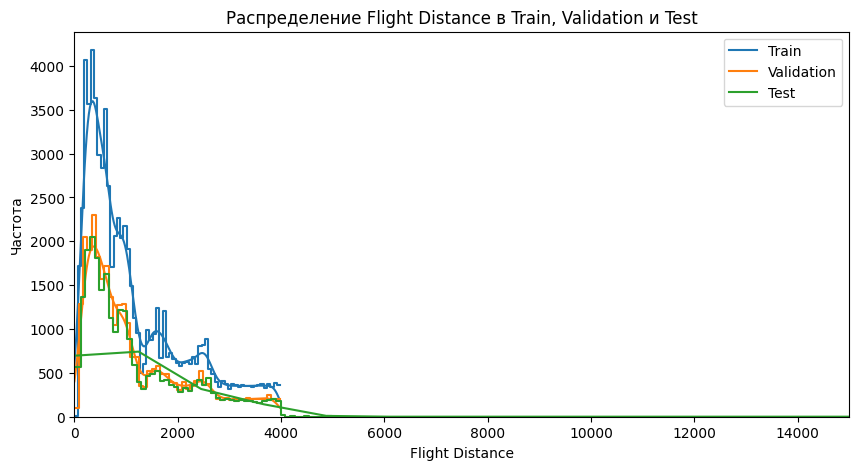

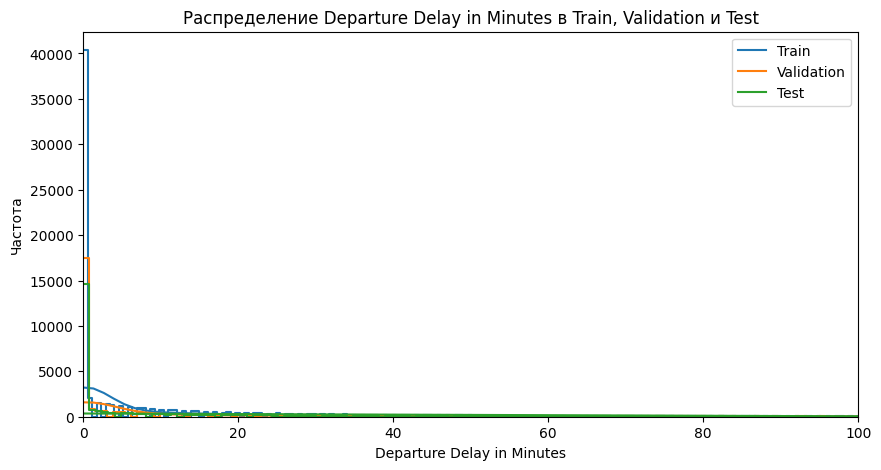

In [ ]:
compare_train_test(selected_features, X_train, X_val, df_test, x_limits)

Вывод: Разбиение правильное, данные похожи во всех частях. Небольшие отличия есть в задержках и дальности полетов, в тесте чуть больше дальних перелетов и меньше больших задержек.

### **Задание 9 (0.25 балла)**

- Замените признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.
- Заново постройте графики континуальных признаков и сделайте вывод по преобразованию

Некоторые признаки полезно рассматривать в логарифмической шкале. Зачем? Она помогает анализировать большие диапазоны изменений (посмотрите на график логарифма).


In [ ]:
X_train["Departure Delay in Minutes"] = np.log1p(X_train["Departure Delay in Minutes"])
X_train["Arrival Delay in Minutes"] = np.log1p(X_train["Arrival Delay in Minutes"])
X_val["Departure Delay in Minutes"] = np.log1p(X_val["Departure Delay in Minutes"])
X_val["Arrival Delay in Minutes"] = np.log1p(X_val["Arrival Delay in Minutes"])
df_test["Departure Delay in Minutes"] = np.log1p(df_test["Departure Delay in Minutes"])
df_test["Arrival Delay in Minutes"] = np.log1p(df_test["Arrival Delay in Minutes"])

Построение.

In [ ]:
depart_arriv_cols = ["Departure Delay in Minutes", "Arrival Delay in Minutes"]

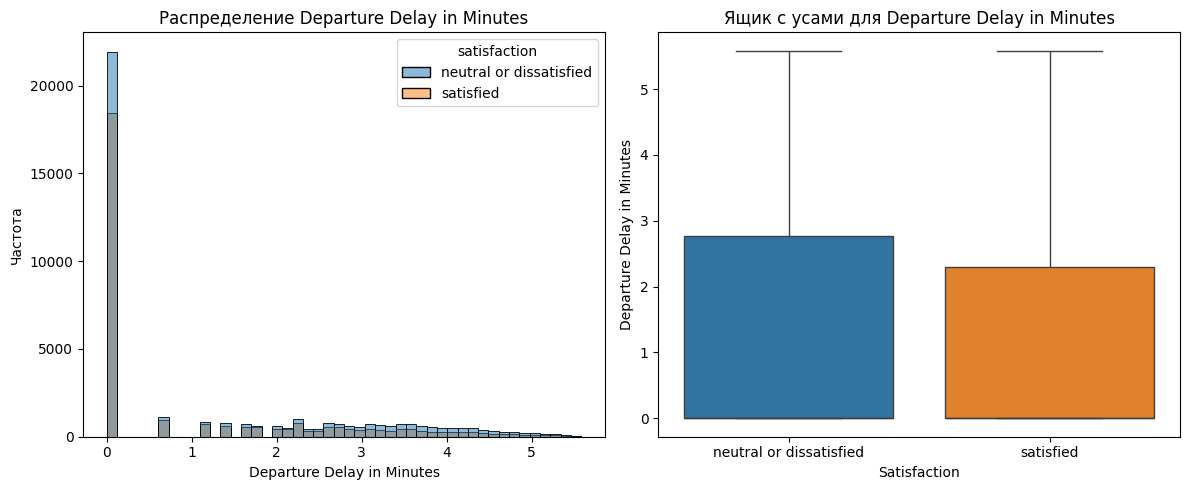

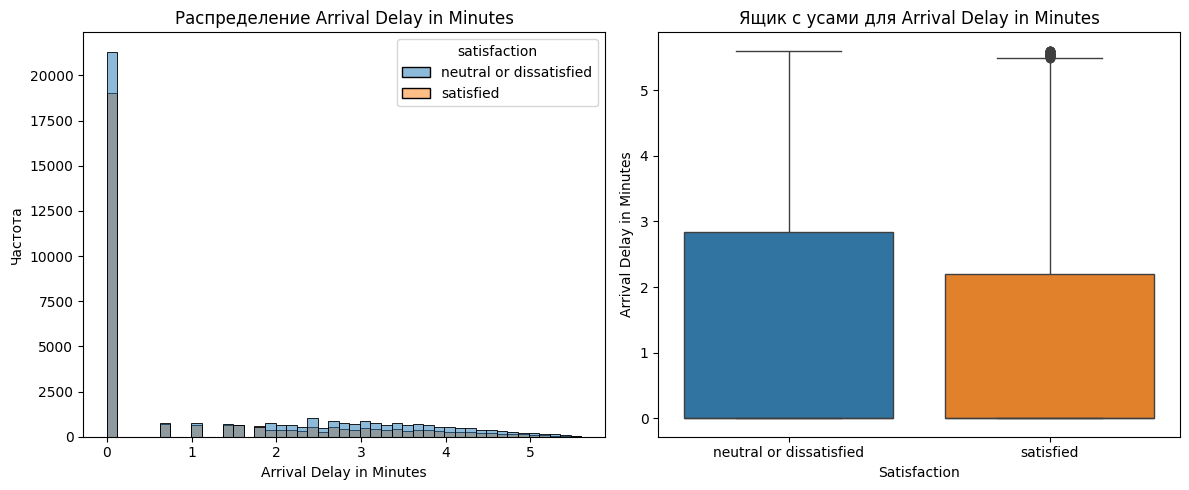

In [ ]:
plot_continuous(depart_arriv_cols, X_train[depart_arriv_cols], y_train)

Выводы:
* До логарифмирования значения были очень смещены вправо (много маленьких, но редкие большие выбросы).
* После логарифмирования распределение стало более сглаженным и ближе к нормальному.
* Теперь большие задержки не так сильно влияют, и их легче анализировать.

### **Задание 10 (0.25 балла)**

Выше вы рассмотрели `boxplot` и графики распределений. Но иногда полезным оказывается `scatterplot, (pairplot)` в seabron. Проверьте, что покажет этот график в нашей задаче.

- Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом.

**Примечание:**
Наблюдений много, так что отрисовка графика вполне может занять несколько минут

In [ ]:
df_train_task_10 = X_train.merge(y_train, left_index=True, right_index=True)

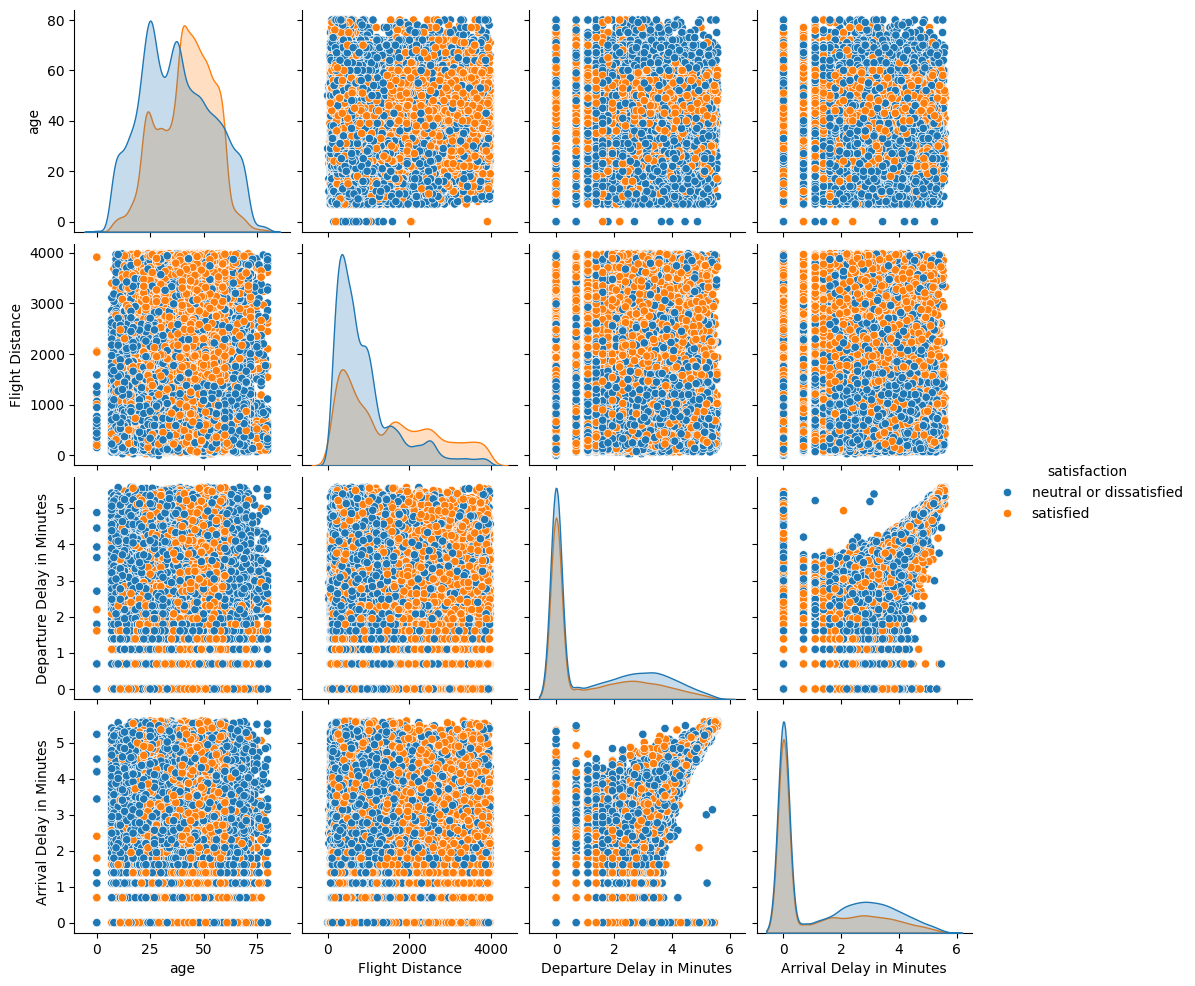

In [ ]:
sns.pairplot(df_train_task_10[continuous_cols + ['satisfaction']], hue="satisfaction")
plt.show()

# **Часть 2. Decision Tree (3 балла)**

### **Задание 11 (0.4 балла)**

Предобработайте данные для алгоритма.
- Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0;
- Закодируйте категориальные признаки методом OHE;

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((71395, 22), (71395,), (30600, 22), (30600,))

In [ ]:
y_train.head()

id
2031     neutral or dissatisfied
11597                  satisfied
74668    neutral or dissatisfied
31602    neutral or dissatisfied
51518                  satisfied
Name: satisfaction, dtype: object

In [ ]:
y_train = (y_train == "satisfied").astype(int)
y_val = (y_val == "satisfied").astype(int)

In [ ]:
y_train.head()

id
2031     0
11597    1
74668    0
31602    0
51518    1
Name: satisfaction, dtype: int64

In [ ]:
encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded_train = encoder.fit_transform(X_train[categorical_cols])
encoded_val = encoder.transform(X_val[categorical_cols])

encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(categorical_cols))
encoded_val_df = pd.DataFrame(encoded_val, columns=encoder.get_feature_names_out(categorical_cols))

X_train = X_train.drop(columns=categorical_cols).reset_index(drop=True)
X_val = X_val.drop(columns=categorical_cols).reset_index(drop=True)

X_train = pd.concat([X_train, encoded_train_df], axis=1)
X_val = pd.concat([X_val, encoded_val_df], axis=1)

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((71395, 23), (71395,), (30600, 23), (30600,))

In [ ]:
X_train.head(1)

age  Flight Distance  Departure Delay in Minutes  \
0  29.0            785.0                         0.0   

   Arrival Delay in Minutes  Inflight wifi service  \
0                       0.0                    2.0   

   Departure/Arrival time convenient  Ease of Online booking  Gate location  \
0                                2.0                     2.0            4.0   

   Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
0             4.0              2.0           3.0                     4.0   

   On-board service  Leg room service  Baggage handling  Checkin service  \
0               4.0               3.0               5.0              4.0   

   Inflight service  cleanliness  gender_Male  \
0               5.0          4.0          0.0   

   Customer Type_disloyal Customer  Type of Travel_Personal Travel  class_Eco  \
0                              1.0                             0.0        0.0   

   class_Eco Plus  
0             0.0

### **Задание 12. (0.1 балла)**

- Обучите дерево решений с параметрами по умолчанию на имеющихся данных.
- Выведите `accuracy_score` для валидационной подвыборки

**Примечание**:

Здесь и далее, где вас просят что-нибудь обучить, выводите **везде** `accuracy_score` для валидационной подвыборки.

In [ ]:
model_tree = DecisionTreeClassifier()
model_tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
y_pred_tree = model_tree.predict(X_val)
accuracy_tree = accuracy_score(y_val, y_pred_tree)

In [ ]:
accuracy_tree

0.942843137254902

## **Анализ построенной модели**

### **Задание 13. (0.5 балла)**

- Посчитайте bias и variance для построенного дерева. Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [ ]:
model_tree_untrained = DecisionTreeClassifier()

In [ ]:
error_dt, bias_dt, var_dt = bias_variance_decomp\
(model_tree_untrained, X_train.values, y_train.values, X_val.values, y_val.values, loss='0-1_loss')
error_dt, bias_dt, var_dt

(0.06209787581699347, 0.04035947712418301, 0.04632565359477124)

### **Задание 14. (0.2 балла)**

Проанализируйте структурные характеристики дерева.
- Какой глубины получилось дерево?
- Сколько в нем листьев?

In [ ]:
depth = model_tree.get_depth()
leaves = model_tree.get_n_leaves()
depth, leaves

(35, 2912)

In [ ]:
from IPython.display import display, Markdown

In [ ]:
display(Markdown(f"Ого! {depth} глубина и {leaves} листьев."))

Ого! 35 глубина и 2912 листьев.

### **Задание 15. (0.3 балла)**

Проанализируйте важность признаков, вычисляемую в дереве по построению.

- Выведите на экран barplot, демонстрирующий оценки важности признаков.
- Укажите, какие признаки оказались наиболее информативными?

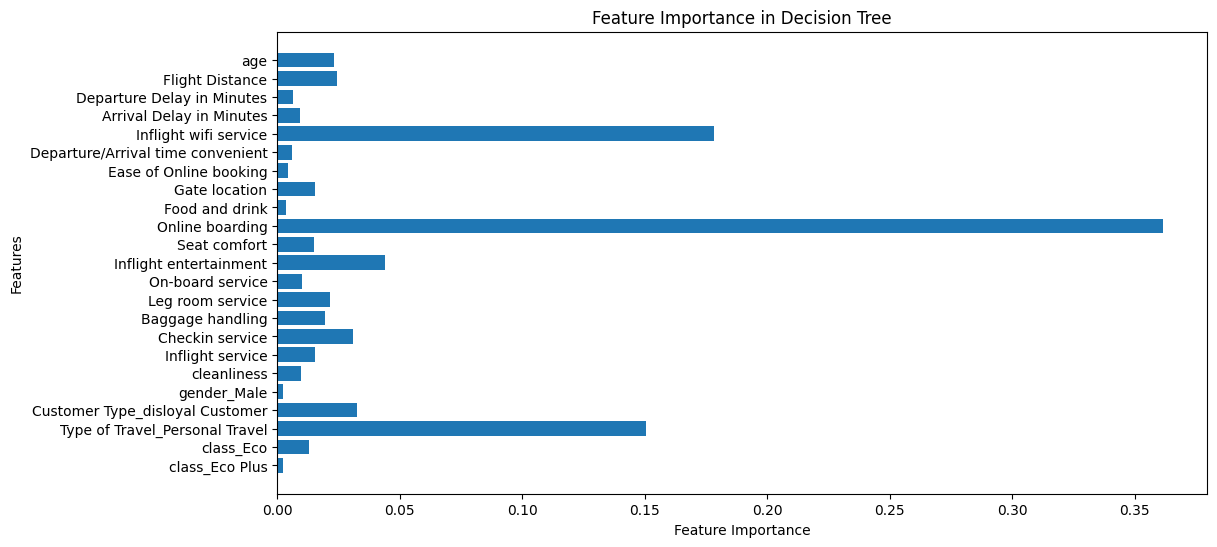

In [ ]:
feature_importances = model_tree.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(12, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Decision Tree")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
important_features = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)[:5]
important_features

[('Online boarding', 0.3615219339300113),
 ('Inflight wifi service', 0.1784111423928646),
 ('Type of Travel_Personal Travel', 0.15072831854644111),
 ('Inflight entertainment', 0.043829634488360296),
 ('Customer Type_disloyal Customer', 0.03256487619456078)]

Самые важные для модели признаки - онлайн регистрация, вай-фай, тип путешествия, развлечения в полете и нелояльные пассажиры.

### **Задание 16. (0.1 балла)**

- Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева.

In [ ]:
features_2_import = ["Online boarding", "Inflight wifi service"]
x_train_2_import = X_train[features_2_import]
x_val_2_import = X_val[features_2_import]

model_tree_2_import = DecisionTreeClassifier(max_depth=5)
model_tree_2_import.fit(x_train_2_import, y_train)

DecisionTreeClassifier(max_depth=5)

In [ ]:
y_pred_2_import = model_tree_2_import.predict(x_val_2_import)
accuracy_2_import = accuracy_score(y_val, y_pred_2_import)
accuracy_2_import

0.8248366013071895

Неплохо. А главное - очень быстро!

### **Задание 17. (0.15 балла)**

- С помощью graphviz визуализируйте получившееся новое дерево решений. Почему предикаты в нем не целые, а кратны 1/2?

In [ ]:
import graphviz
dot_data = export_graphviz(
    model_tree_2_import, feature_names=features_2_import,
    class_names=["neutral or dissatisfied", "satisfied"], filled=True, rounded=True, special_characters=True
)
graph = graphviz.Source(dot_data)

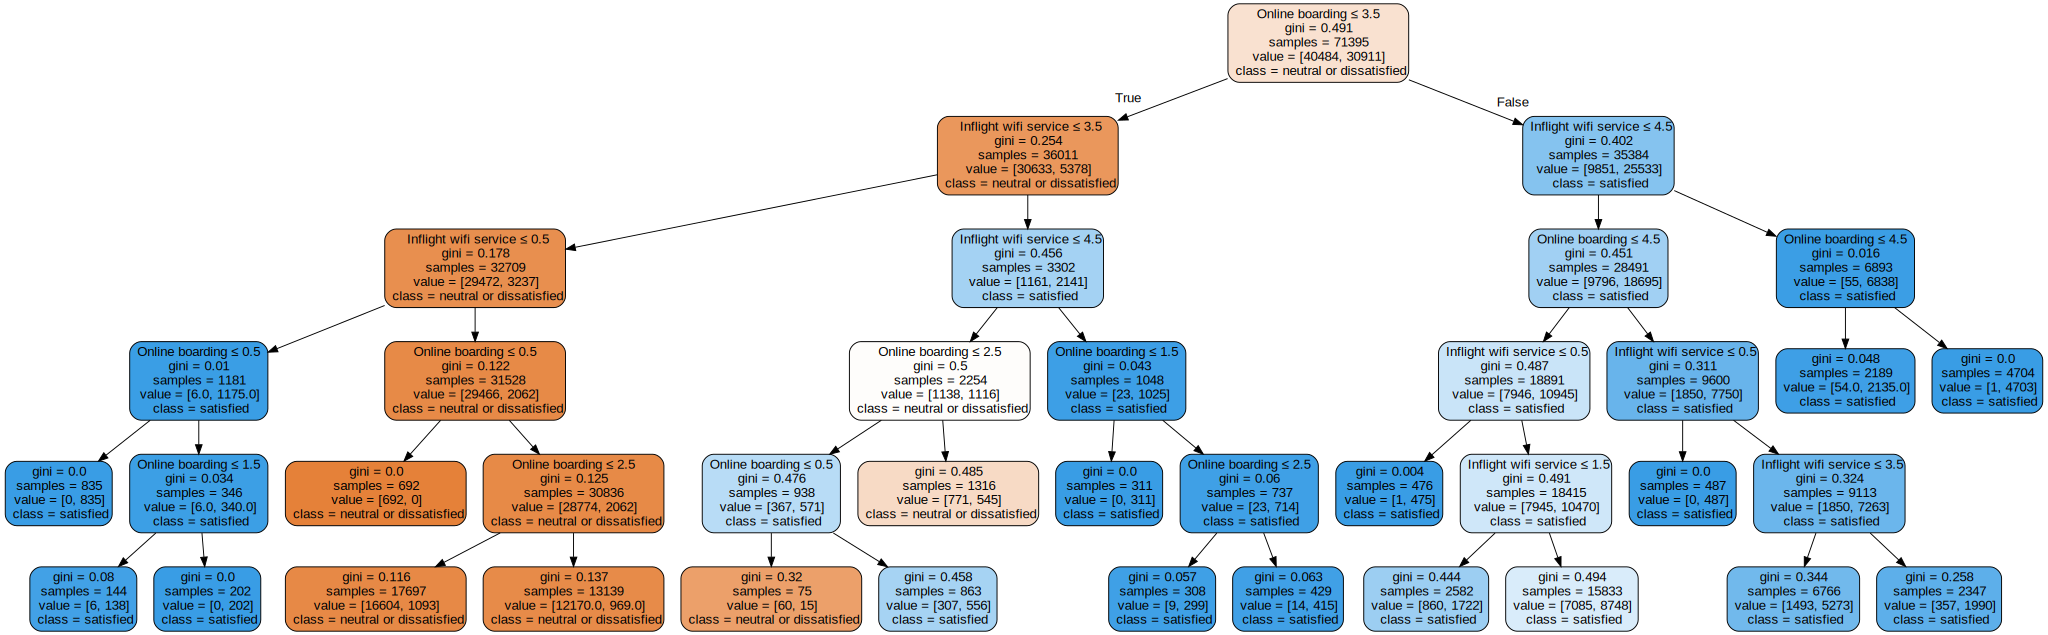

In [ ]:
graph

In [ ]:
X_train[features_2_import].head()

Online boarding  Inflight wifi service
0              2.0                    2.0
1              2.0                    0.0
2              3.0                    3.0
3              5.0                    4.0
4              5.0                    5.0

Если признаки являются дискретными (например, оценки сервиса от 1 до 5), дерево решений выбирает границы разбиения между возможными значениями. В данном случае шаг 1/2 — это среднее значение между двумя соседними категориями (0 и 1), что позволяет алгоритму корректно разделять данные.

### **Задание 18. (0.25 балла)**

- Теперь отобразите его функцией `plot_tree()` из sklearn.
- Проанализируйте — ссимметричным ли получилось дерево? И хорошо ли это, или нет?

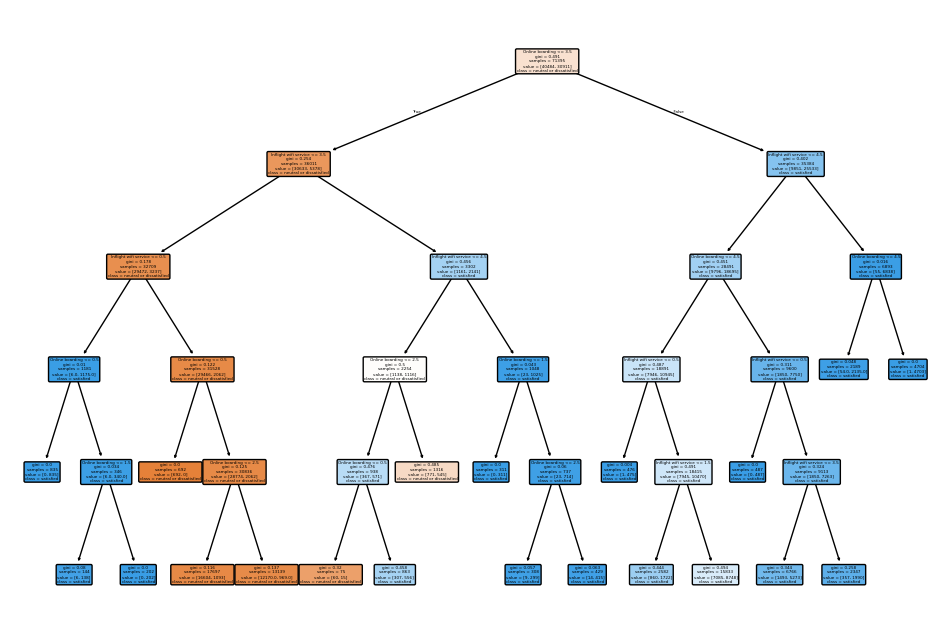

In [ ]:
plt.figure(figsize=(12, 8))
plot_tree(model_tree_2_import, feature_names=features_2_import,
          class_names=["neutral or dissatisfied", "satisfied"], filled=True, rounded=True)
plt.show()

Дерево получилось несимметричным. Это может свидетельствовать о неравномерном распределении данных. Это не всегда хорошо, так как более сбалансированное дерево в целом лучше обобщает данные, а менее сбалансированное склонно к переобучению.

### **Задание 19. (0.5 балла)**

- Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева. Отметьте на графике только первые 100 объектов обучающей выборки

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


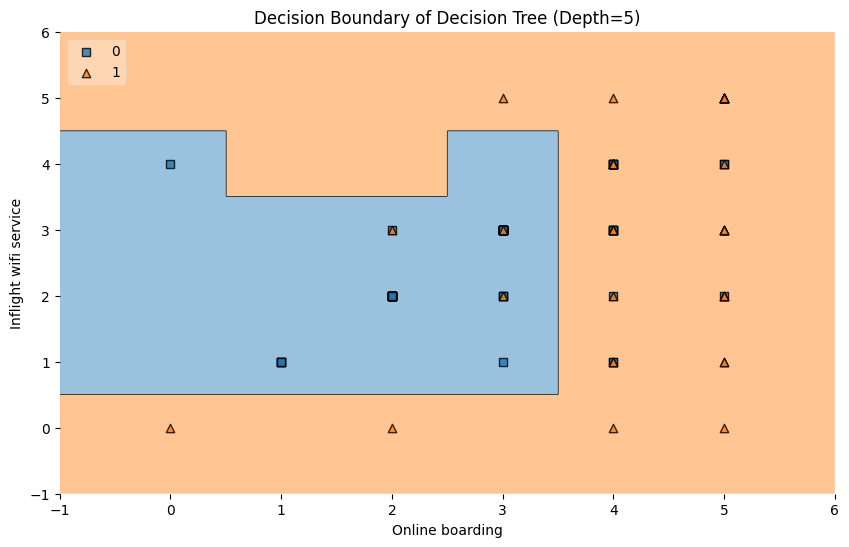

In [ ]:
x_train_100 = X_train[features_2_import].iloc[:100].values
y_train_100 = y_train.iloc[:100].values

plt.figure(figsize=(10, 6))
plot_decision_regions(x_train_100, y_train_100, clf=model_tree_2_import, legend=2)
plt.xlabel("Online boarding")
plt.ylabel("Inflight wifi service")
plt.title("Decision Boundary of Decision Tree (Depth=5)")
plt.show()

### **Деревья решений. Теоретическая вставка**

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это!

In [ ]:
x_train_example = X_train[features_2_import].copy()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local

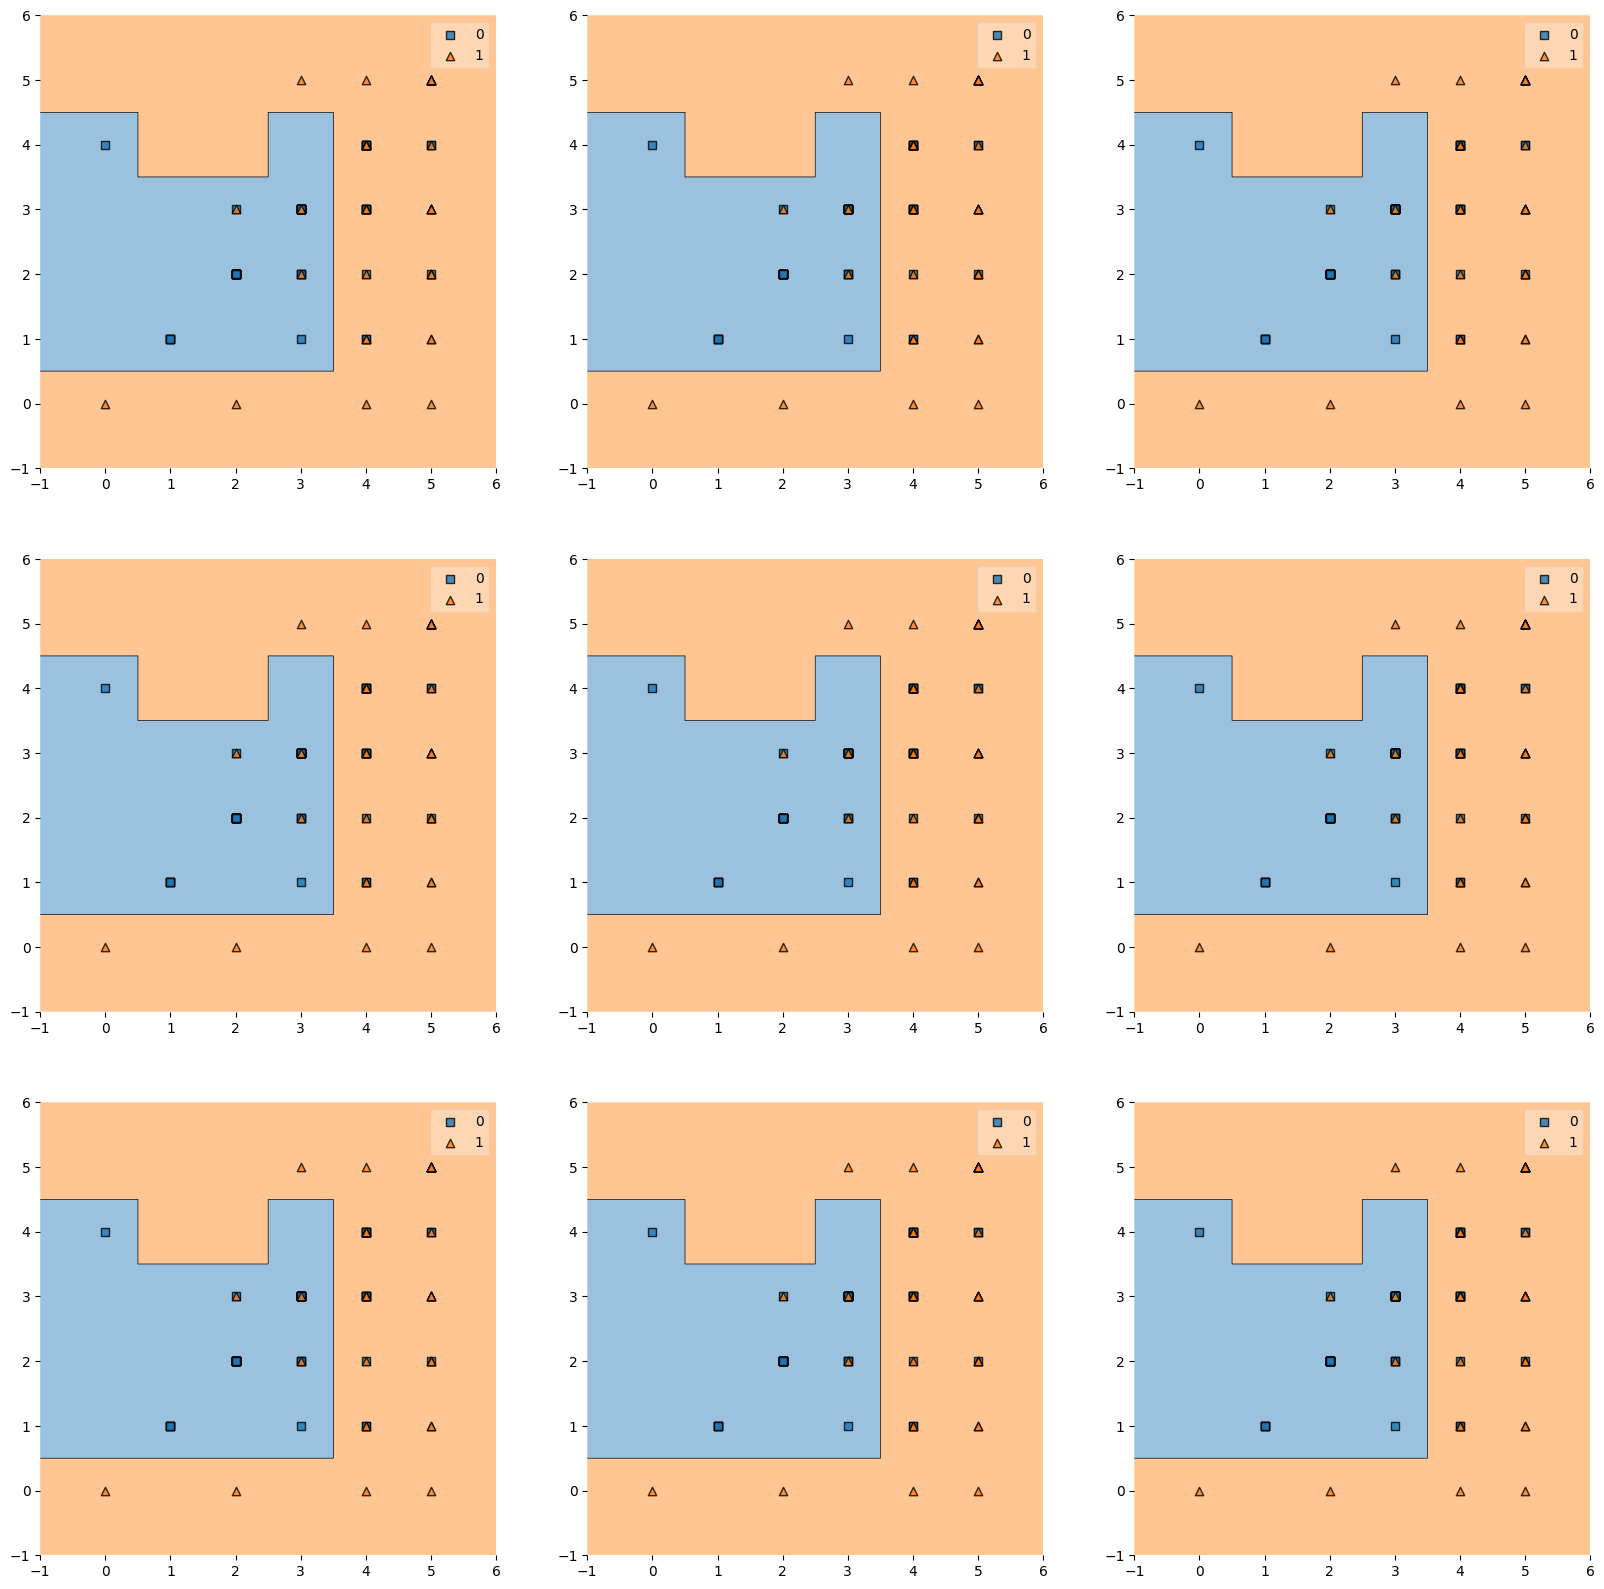

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(x_train_example.index, size=x_train_example.shape[0] - 5000, replace=False)

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(x_train_example.loc[inds, :], y_train.iloc[inds])

        plot_decision_regions(clf=tree_exp, X=x_train_example.iloc[:100, :].values, y=y_train.iloc[:100].values.ravel(), ax=ax[row][col])

plt.show()

**Смотрите как двигается гранится, а ведь мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!**

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [ ]:
# замените X_train_example на вашу переменную (ohe-encoded)

%%time
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train, y_train)
    y_predicted_train = DT.predict(X_train)
    y_predicted_val = DT.predict(X_val)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

CPU times: user 5.22 s, sys: 6.48 ms, total: 5.23 s
Wall time: 5.21 s


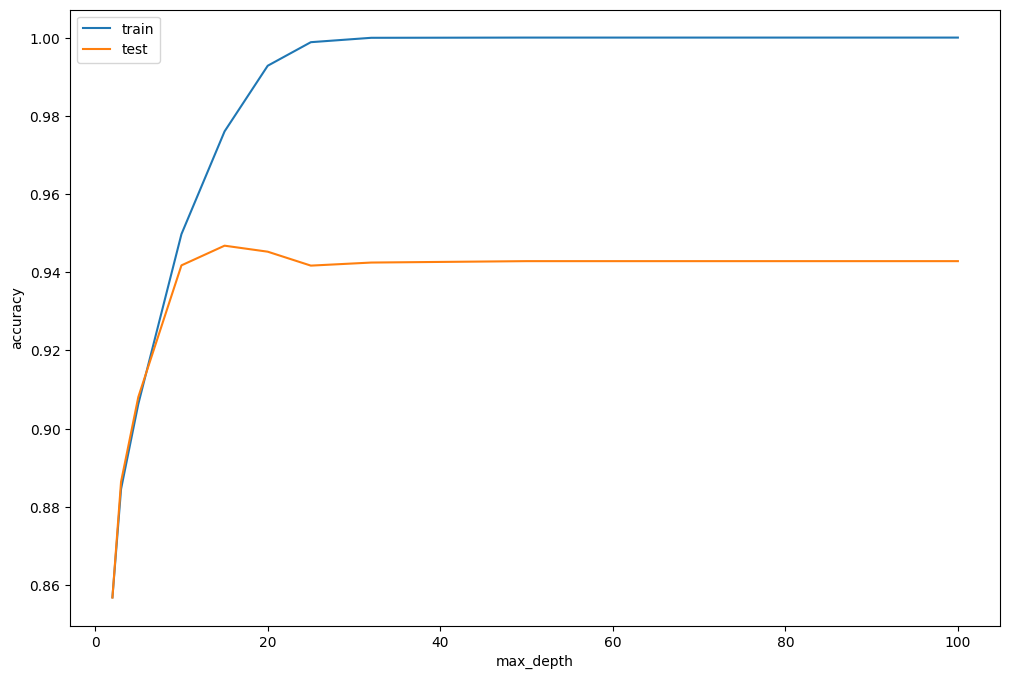

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## **Возвращение к задаче**

### **Задание 20. (0.4 балла)**

- На кроссвалидации подберите оптимальные гиперпараметры для дерева решений *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*.
- Удалось ли улучшить качество предсказаний подбором гиперпараметров?

In [ ]:
%%time
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'criterion': ['gini', 'entropy']
}

grid_search_tree = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_tree.fit(X_train, y_train)

best_model_tree = grid_search_tree.best_estimator_

y_pred_grid_tree = best_model_tree.predict(X_val)
accuracy_grid_tree = accuracy_score(y_val, y_pred_grid_tree)

CPU times: user 2.9 s, sys: 657 ms, total: 3.56 s
Wall time: 2min 15s


In [ ]:
grid_search_tree.best_params_, accuracy_grid_tree, accuracy_tree

({'criterion': 'entropy',
  'max_depth': 15,
  'min_samples_leaf': 2,
  'min_samples_split': 10},
 0.9519607843137254,
 0.942843137254902)

In [ ]:
display(Markdown(f"Да. Accuracy удалось чуть увеличить с {accuracy_tree:.2f} до {accuracy_grid_tree:.2f}. Неплохо!"))

Да. Accuracy удалось чуть увеличить с 0.94 до 0.95. Неплохо!

### **Задание 21. (0.1 балла)**

- Сохраните лучшее дерево в pickle

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [ ]:
with open('DT.pkl', 'wb') as f:
    pickle.dump(best_model_tree, f)

# **Часть 3. Random Forest (4.25 балла)**

### **Задание 22. (0.05 балла)**
- Обучите случайный лес с параметрами по умолчанию

In [ ]:
model_forest = RandomForestClassifier()
model_forest.fit(X_train, y_train)
y_pred_forest = model_forest.predict(X_val)
accuracy_forest = accuracy_score(y_val, y_pred_forest)
accuracy_forest

0.9605882352941176

Ого. Лучше лучшего дерева!

### **Задание 23. (0.15 балла)**
- Выведите калибровочную кривую для полученного ансамбля

<Figure size 800x600 with 0 Axes>

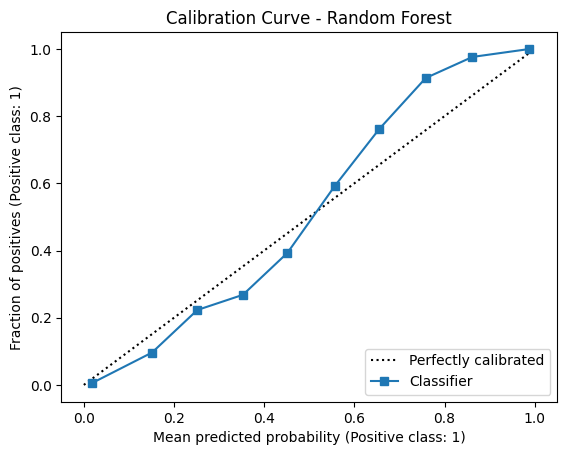

In [ ]:
prob_forest = model_forest.predict_proba(X_val)[:, 1]

plt.figure(figsize=(8, 6))
CalibrationDisplay.from_predictions(y_val, prob_forest, n_bins=10)
plt.title("Calibration Curve - Random Forest")
plt.show()

Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

### **Задание 24. (0.4 балла)**

- Вспомните (или выведите), корректно ли деревья предсказывают вероятности?

Деревья часто некорректно предсказывают вероятности, и вот, почему:
* Деревья принимают “жесткие” решения – в каждом листе хранится доля объектов определенного класса, но эти оценки могут быть ненадежными, особенно если в листе мало объектов.
* Случайный лес сглаживает прогнозы, усредняя вероятности по деревьям, но это не всегда приводит к хорошей калибровке.
* Обычно вероятности в случайном лесе имеют смещение к 0 и 1 – это означает, что модель переоценивает свою уверенность.

### **Задание 25. (0.15 балла)**
- Обучите логистическую регрессию так, чтобы она сошлась
- Отобразите её калибровочную кривую

In [ ]:
model_logreg = LogisticRegression(max_iter=7000)
model_logreg.fit(X_train, y_train)
y_pred_logreg = model_logreg.predict(X_val)
accuracy_logreg = accuracy_score(y_val, y_pred_logreg)
accuracy_logreg

0.8756209150326797

<Figure size 800x600 with 0 Axes>

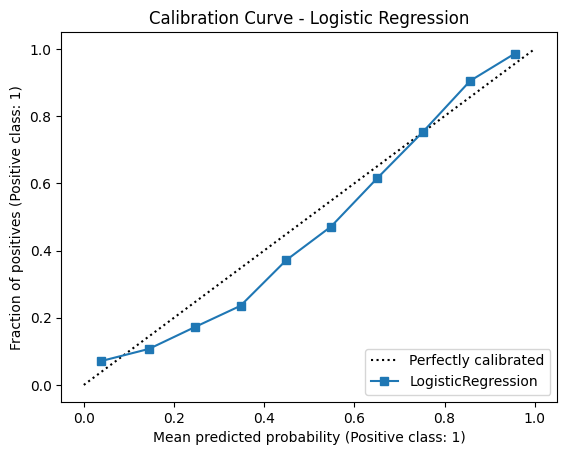

In [ ]:
plt.figure(figsize=(8, 6))
CalibrationDisplay.from_estimator(model_logreg, X_val, y_val, n_bins=10)
plt.title("Calibration Curve - Logistic Regression")
plt.show()

Мы немного переоцениваем предсказанные низкие вероятности

### **Задание 26. (0.2 балла)**
- Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?

Отвечу несколькими пунктами:
* Прямая интерпретация - использует сигмоиду, которая преобразует линейную комбинацию признаков в вероятность.
* Максимизация правдоподобия - оптимизирует функцию, которая минимизирует отклонение предсказанных вероятностей от истинных.
* Гладкость и монотонность - вероятности распределены равномерно, без резких скачков.
* Хорошая калибровка - на калибровочной кривой обычно близка к диагонали, в отличие от деревьев решений.

### **Задание 27. (0.35 балла)**

Предлагаем вам попробовать откалибровать вероятности обученного случайного леса!

- Откалибруйте вероятности, при помощи логистической и изотонической регрессий.
- Интерпретируйте полученные результаты

In [ ]:
prob_forest = model_forest.predict_proba(X_val)[:, 1]
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(prob_forest.reshape(-1, 1), y_val)
prob_forest_log = log_reg.predict_proba(prob_forest.reshape(-1, 1))[:, 1]

<Figure size 1000x600 with 0 Axes>

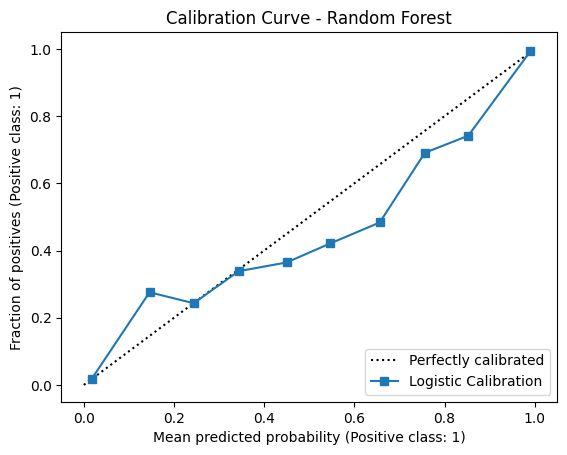

In [ ]:
plt.figure(figsize=(10, 6))
CalibrationDisplay.from_predictions(y_val, prob_forest_log, n_bins=10, name="Logistic Calibration")
plt.title("Calibration Curve - Random Forest")
plt.show()

Модель случайного леса была плохо откалибрована, и логистическая регрессия только частично скорректировала прогнозы.

In [ ]:
iso_reg = IsotonicRegression(out_of_bounds="clip")
iso_reg.fit(prob_forest, y_val)
prob_forest_iso = iso_reg.predict(prob_forest)

<Figure size 1000x600 with 0 Axes>

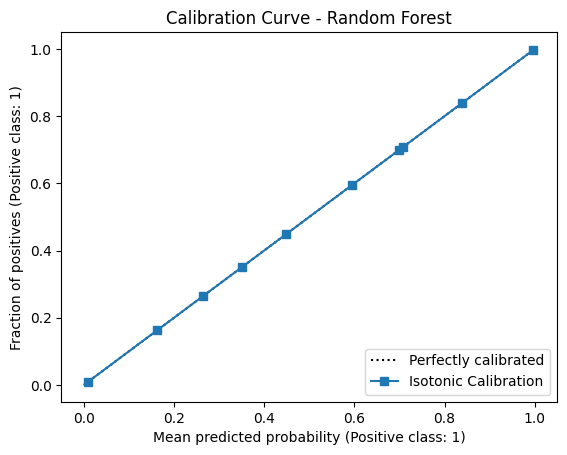

In [ ]:
plt.figure(figsize=(10, 6))
CalibrationDisplay.from_predictions(y_val, prob_forest_iso, n_bins=10, name="Isotonic Calibration")
plt.title("Calibration Curve - Random Forest")
plt.show()

Изотоническая регрессия практически идеально подстроила вероятности под реальную частоту положительных классов.

### **Задание 28. (0.2 балла)**
- Опишите другие возвожные подходы к калибровке вероятностей (со ссылками на источники)

1. Гистограммная калибровка (Histogram Binning): Делит диапазон предсказанных вероятностей на интервалы (бины) и заменяет предсказанные значения на эмпирические частоты в этих интервалах [ссылка тут](https://alexanderdyakonov.wordpress.com/2020/03/27/%d0%bf%d1%80%d0%be%d0%b1%d0%bb%d0%b5%d0%bc%d0%b0-%d0%ba%d0%b0%d0%bb%d0%b8%d0%b1%d1%80%d0%be%d0%b2%d0%ba%d0%b8-%d1%83%d0%b2%d0%b5%d1%80%d0%b5%d0%bd%d0%bd%d0%be%d1%81%d1%82%d0%b8/)
2. Деревья калибровки (Probability Calibration Trees): Используют деревья решений для разделения пространства признаков на области, в каждой из которых применяется отдельная модель калибровки [ссылка тут](https://arxiv.org/pdf/1808.00111)
3. Калибровка с помощью сглаживающих сплайнов (Spline-Based Calibration): Применяет сглаживающие сплайны для моделирования функции калибровки [ссылка тут](https://arxiv.org/pdf/1809.07751)

### **Задание 29. (0.5 баллa)**

Проанализируйте лес.
- Посчитайте разброс и смещение полученного случайного леса (до калибровки).
- Оличаются ли они от полученных для дерева решений?
- Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?

In [ ]:
error_dt, bias_dt, var_dt

(0.06209787581699347, 0.04035947712418301, 0.04632565359477124)

Далее с дефолтными параметрами bias_variance_decomp работал более 30 минут, и я чуть урезал выборку с n_estimators.

In [ ]:
model_forest_untrained = RandomForestClassifier(n_estimators=50, n_jobs=-1)

Тут ноутбук крашится по памяти, поэтому попробуем ее почистить.

In [ ]:
!pip install pympler -q

In [ ]:
from pympler import muppy, summary

all_objects = muppy.get_objects()

memory_summary = summary.summarize(all_objects)
summary.print_(memory_summary)

                           types |   # objects |   total size
================================ | =========== | ============
       numpy.ma.core.MaskedArray |          77 |    549.33 MB
     pandas.core.frame.DataFrame |          20 |    119.36 MB
                   numpy.ndarray |        4161 |     88.13 MB
                             str |      214639 |     42.01 MB
                            code |       74570 |     29.86 MB
                            dict |       76562 |     23.07 MB
                            type |       10379 |     12.46 MB
       pandas.core.series.Series |          66 |     11.74 MB
  pandas.core.indexes.base.Index |          36 |      6.37 MB
                           tuple |       90568 |      5.58 MB
  pandas._libs.index.Int64Engine |           5 |      4.03 MB
                            list |       31757 |      2.87 MB
                     abc.ABCMeta |        1411 |      2.21 MB
                             set |        5665 |      2.07 MB
        

In [ ]:
import gc

for obj in gc.get_objects():
    try:
        if isinstance(obj, np.ndarray):
            del obj
    except Exception:
        pass

gc.collect()

0

In [ ]:
%%time
error_forest, bias_forest, var_forest = bias_variance_decomp\
(model_forest_untrained, X_train.values, y_train.values, X_val.values, y_val.values, loss='0-1_loss', num_rounds=100)
error_forest, bias_forest, var_forest

CPU times: user 11min 23s, sys: 3.03 s, total: 11min 26s
Wall time: 6min 51s


(0.04157483660130718, 0.039477124183006536, 0.011140196078431372)

Выводы:
1. Ошибка (error) случайного леса ниже, чем у дерева решений. Это соответствует теоретическим ожиданиям, так как ансамблирование (усреднение предсказаний многих деревьев) снижает ошибку модели.
2. Смещение (bias) почти одинаковое. Это совпадает с теорией: случайный лес не снижает смещение, так как каждый отдельный классификатор обучается на подмножестве данных и делает “грубые” прогнозы.
3. Разброс (variance) у случайного леса значительно ниже. Ожидаемый эффект случайного леса, так как ансамблирование снижает вариативность модели за счет усреднения предсказаний множества деревьев.

### **Задание 30. (0.5 баллa)**

- Вычислите разложение ошибки для логистической регрессии (ванильной, которую вы обучили для решения задачи в задании 25, а не той, что использовали для калибровки)
- Сравните полученные результаты с предыдущими.
- Объясните природу этих результатов

In [ ]:
model_logreg_untrained = LogisticRegression(max_iter=7000)

In [ ]:
%%time
error_logreg, bias_logreg, var_logreg = bias_variance_decomp(
    model_logreg_untrained, X_train.values, y_train.values, X_val.values, y_val.values, loss='0-1_loss', num_rounds=100)
error_logreg, bias_logreg, var_logreg

CPU times: user 54min 49s, sys: 25min 6s, total: 1h 19min 55s
Wall time: 49min 19s


(0.12420359477124183, 0.12431372549019608, 0.00407483660130719)

Выводы: ошибка и баес в несколько раз хуже, чем получалось у единичного дерева решений, зато верианс на порядок ниже. Интересно!


### **Задание 31. (0.8 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса, используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [ ]:
from scipy.stats import randint, uniform

param_grid_forest = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 5),
    'min_samples_leaf': randint(1, 3),
    'max_features': uniform(0.3, 0.7)
}

In [ ]:
%%time
random_search = RandomizedSearchCV(
    RandomForestClassifier(),
    param_distributions=param_grid_forest,
    n_iter=20,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
CPU times: user 36.7 s, sys: 1.07 s, total: 37.8 s
Wall time: 10min 3s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f82fcee2cd0>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f82f88e1810>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f82fc041690>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f82fc7cb190>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f82f8ddfe10>},
                   scoring='accuracy', verbose=1)

In [ ]:
best_model_forest = random_search.best_estimator_

y_pred_forest_best = best_model_forest.predict(X_val)
accuracy_forest_best = accuracy_score(y_val, y_pred_forest_best)
random_search.best_params_, accuracy_forest_best

({'max_depth': 9,
  'max_features': 0.7005670885813015,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 171},
 0.9482679738562092)

Жаль. Лучший случайный лес по accuracy оказался хуже дефолтного. В идеале надо дольше перебирать или использовать optuna.

## **Случайный лес. Вставка теории**

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [ ]:
# замените X_train_enc на ваш трейн

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too fe

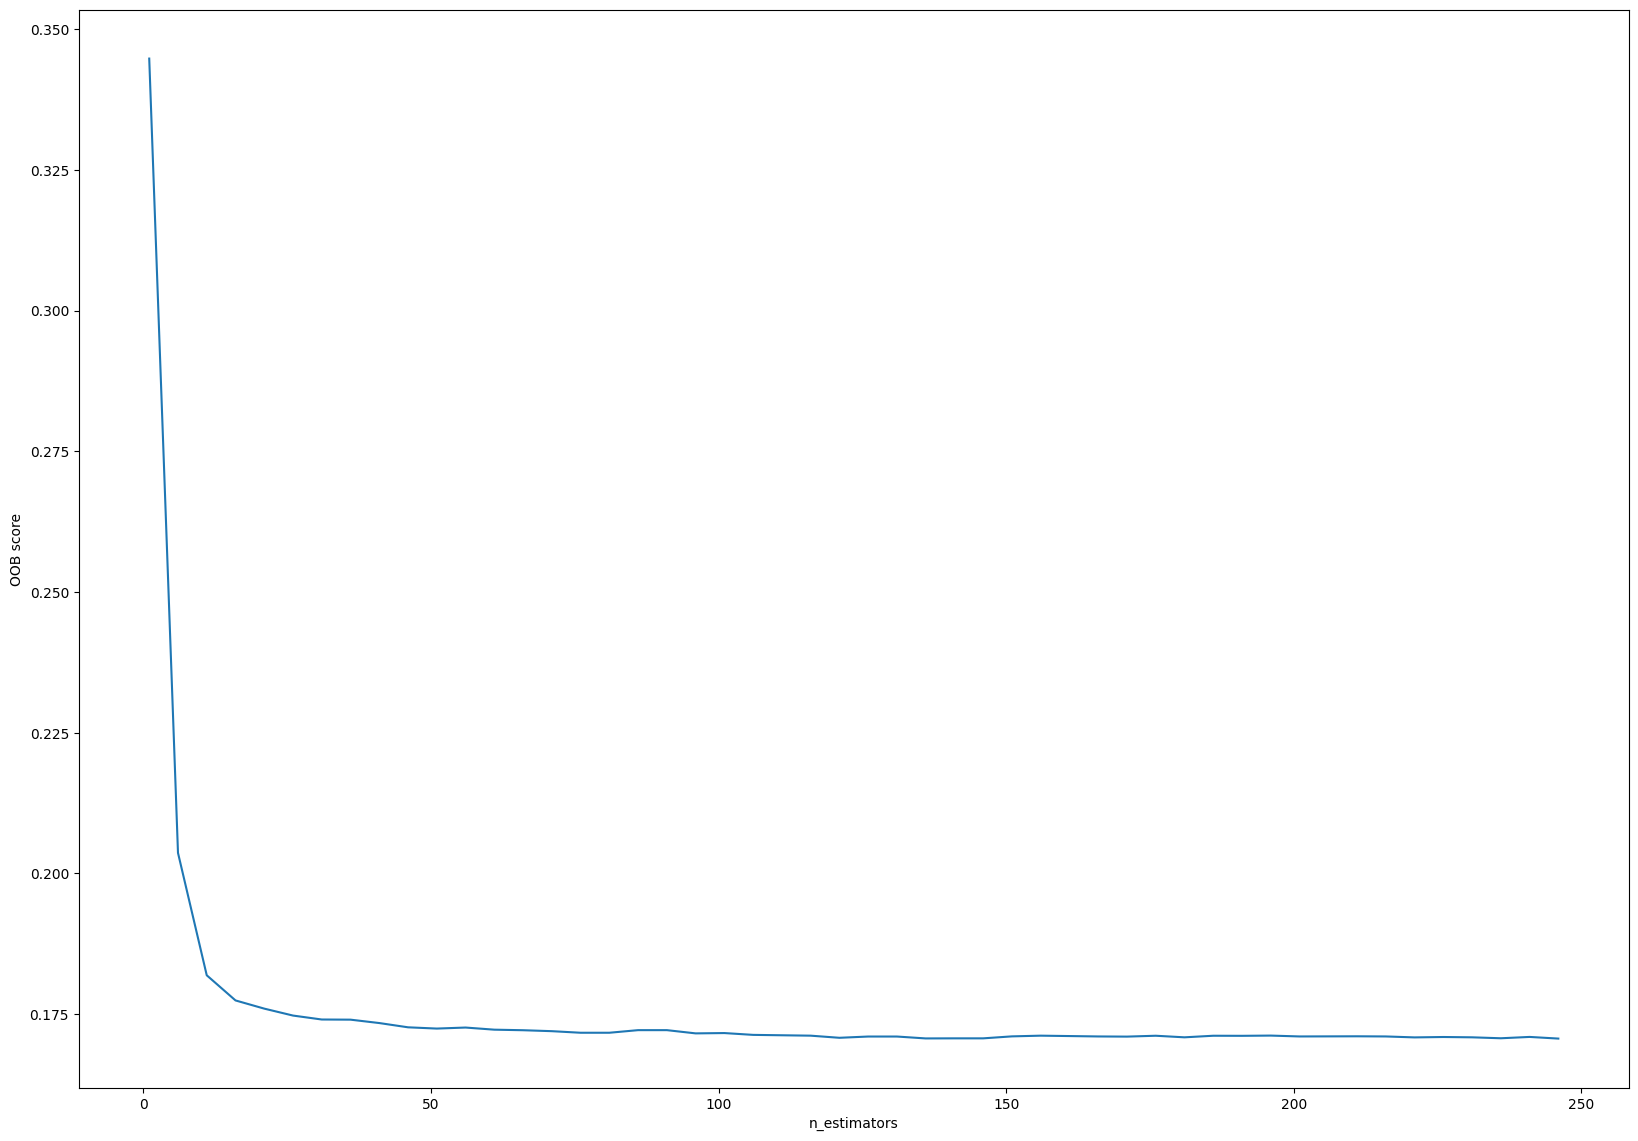

In [ ]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

**Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной

## **Возвращение к задаче**

### **Задание 32. (0.6 баллa)**

- Отобразите`feature_importances_` вашего лучшего случайного леса
- Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму


In [ ]:
feature_importance_forest = best_model_forest.feature_importances_
feature_importance_tree = model_tree.feature_importances_
feature_names = X_train.columns

In [ ]:
indices_forest = np.argsort(feature_importance_forest)[::-1]
indices_tree = np.argsort(feature_importance_tree)[::-1]

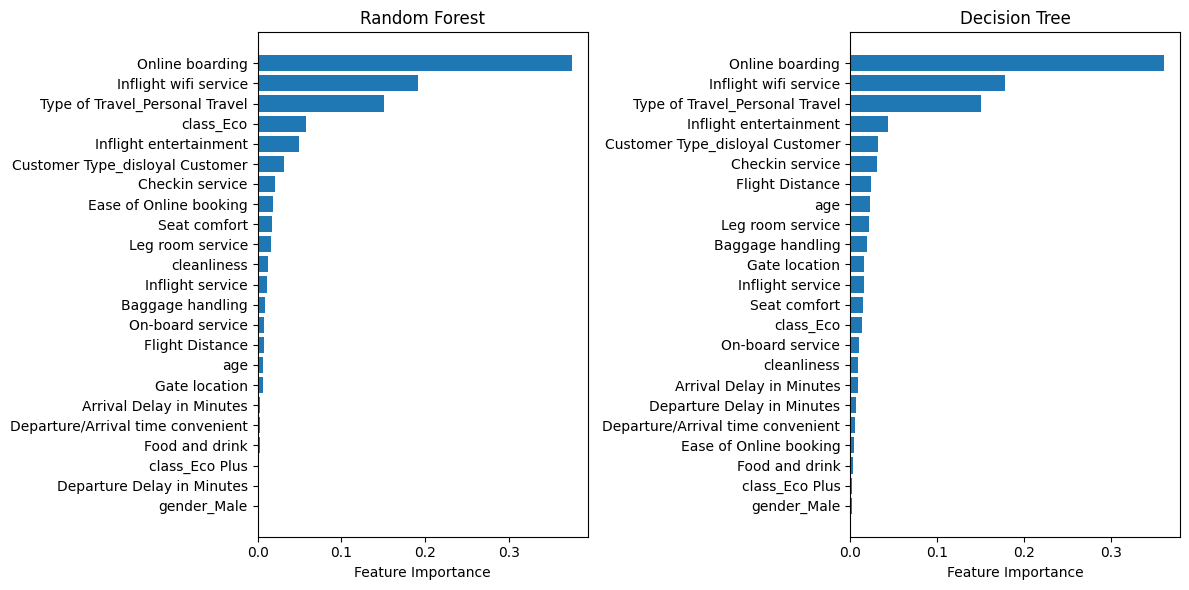

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.barh(range(len(feature_names)), feature_importance_forest[indices_forest], align='center')
plt.yticks(range(len(feature_names)), np.array(feature_names)[indices_forest])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Random Forest")

plt.subplot(1, 2, 2)
plt.barh(range(len(feature_names)), feature_importance_tree[indices_tree], align='center')
plt.yticks(range(len(feature_names)), np.array(feature_names)[indices_tree])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Decision Tree")

plt.tight_layout()
plt.show()

Ого! Различия начинаются только с 4-ой фичи.

### **Задание 33. (0.1 баллa)**

- Случайный лес, дающий лучший скор, [сохраните в pickle](https://scikit-learn.ru/stable/model_persistence.html)

In [ ]:
with open("best_forest.pkl", "wb") as f:
    pickle.dump(best_model_forest, f)

### **Задание 34. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

In [ ]:
forest_params = {
    'max_depth': 9,
    'max_features': 0.7005670885813015,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 171,
    'random_state': 42
}

branded_forest = RandomForestClassifier(**forest_params)
branded_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, max_features=0.7005670885813015,
                       n_estimators=171, random_state=42)

In [ ]:
X_sample.columns

Index(['age', 'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'cleanliness', 'gender_Male', 'Customer Type_disloyal Customer',
       'Type of Travel_Personal Travel', 'class_Eco', 'class_Eco Plus'],
      dtype='object')

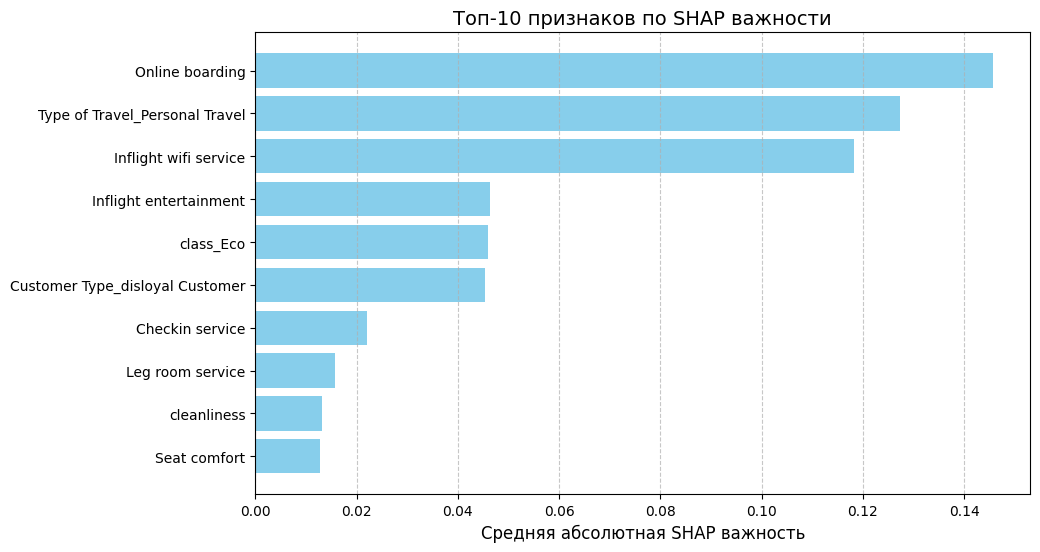

In [ ]:
sample_indices = np.random.choice(X_train.index, size=3000, replace=False)
X_sample = X_train.loc[sample_indices]

explainer = shap.TreeExplainer(branded_forest)
shap_values = explainer.shap_values(X_sample)

shap_values_class_1 = shap_values[:, :, 1]

shap_importances = np.abs(shap_values_class_1).mean(axis=0)

shap_importances_df = pd.DataFrame({
    'feature': X_sample.columns,
    'importance': shap_importances
}).sort_values(by='importance', ascending=False)

top_shap_features = shap_importances_df.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_shap_features['feature'], top_shap_features['importance'], color='skyblue')
plt.title('Топ-10 признаков по SHAP важности', fontsize=14)
plt.xlabel('Средняя абсолютная SHAP важность', fontsize=12)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Вторая и третья фичи поменялись местами по сравнению со стандарнтым фичиимпортанс, 4 и 5 фичи - тоже, но они идут прям рядом. Онлайн боардинг так не отрывается от других фичем по важности. В целом, лучше доверять шапам, чем коробочному фичи импортансу.

### **Бонус (0.1 балл)**

- Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется?

1. Различные объяснители:
* TreeExplainer: Оптимизирован для древовидных моделей, таких как Random Forest и XGBoost.
* DeepExplainer: Предназначен для нейронных сетей.
* KernelExplainer: Универсальный метод для любых моделей.
2. Инструменты визуализации:
* Summary Plot: Показывает влияние признаков на предсказания модели.
* Dependence Plot: Отображает зависимость между значением признака и его влиянием на предсказание.
* Force Plot: Иллюстрирует вклад каждого признака в конкретное предсказание.
3. Оценка взаимодействия признаков:
* SHAP позволяет анализировать, как комбинации признаков совместно влияют на предсказания модели.


### **Бонус (0.5 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


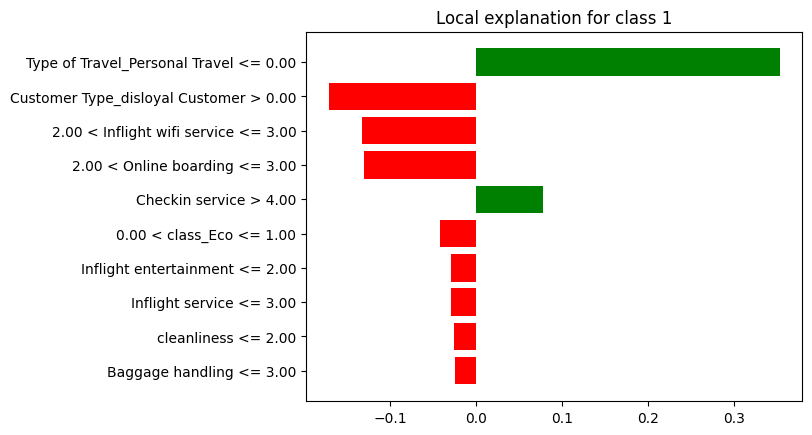

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    training_labels=y_train.values,
    mode="classification",
    feature_names=X_train.columns,
    class_names=[0, 1],
    discretize_continuous=True
)

idx = 42
exp = explainer.explain_instance(X_val.iloc[idx].values, best_model_forest.predict_proba, num_features=10)

exp.as_pyplot_figure()
plt.show()

Очень интересно. Особенно то, что online boarding только в топ-4, хотя и в обычном импортансе и в шапах он был первым. Также налядно, куда какая фича двигает предсказание нашего положительного класса. Топ-2 фича в шапах стала топ-1 фичей в Лайм, интересно. Сколько библиотек - столько и мнений, получается!

## Котобонус!

0.25 балла

Пусть будет кот Елены Кантонистовой.

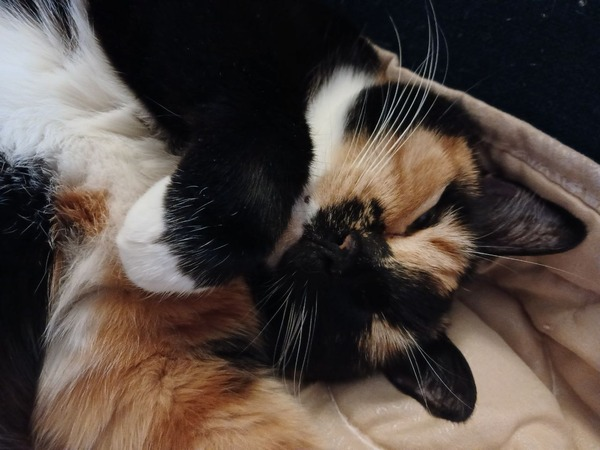

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?

Супер ДЗ! Просто нет слов! Очень понравилось!